# **Introduction to SN GAN 💡**

**Spectral Normalization Generative Adversarial Networks (SN GANs)** represent a significant advancement in the **realm of deep learning**, building upon the foundation laid by **Deep Convolutional Generative Adversarial Networks (DC GANs).** **DC GANs**, at their core, consist of a **dynamic interplay** between **a generator and a discriminator**, both leveraging **convolutional layers** in their architecture.

The **generator's primary objective** is to **craft synthetic images**, while the **discriminator's role is to distinguish between authentic and fabricated images**. This nuanced exchange creates a **dynamic training game**, wherein both entities **continually refine their strategies**. The generator refines its ability to produce **increasingly realistic synthetic images**, while the discriminator hones its **knack for differentiating between genuine and generated content**. The convergence of this **iterative process** marks the **culmination of training** when the generator achieves proficiency in **generating synthetic images that closely resemble authentic ones.**

However, **conventional architectures**, in their pursuit of progress, encounter **pitfalls such as mode collapse and various other training issues**. These challenges impede the seamless evolution of the **generator-discriminator interplay**, hampering the network's overall performance.

Enter **Spectral Normalization GANs**, a groundbreaking solution to the training woes **afflicting traditional architectures**. **Spectral normalization** is a **novel technique** applied to the **convolutional layers within the discriminator**. This technique involves **constraining the spectral norm** of the **weight matrices**, ensuring a **more stable and controlled learning process**.

In essence, **spectral normalization** provides a **robust regularization mechanism** that mitigates issues like **mode collapse and improves overall convergence during training**. By stabilizing the learning dynamics, **SN GANs foster** a **more reliable** and **efficient training environment**, facilitating the **generator's acquisition of the skills necessary to generate convincing synthetic images.**

This innovative approach injects a **breath of fresh air** into the **realm of GANs**, offering a solution to **long-standing challenges and elevating the overall performance of deep learning models**. As the generator refines its artistry, and the **discriminator sharpens its discernment**, the dance between **real and synthetic** becomes a captivating spectacle in the **world of AI**, proving that progress can indeed be both **sophisticated and entertaining**.

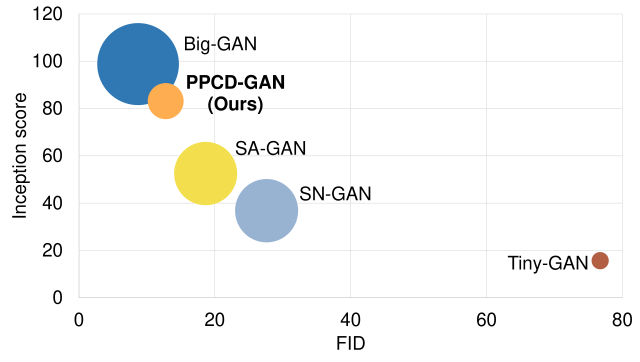

----

## **Why Spectral Normalization works?**


The intuition behind applying **spectral normalization in Generative Adversarial Networks (GANs)** lies in its ability to **stabilize and regularize the training process,** particularly within the **discriminator network**. **Spectral normalization** works by constraining the **Lipschitz constant of the discriminator**, which has a profound impact on the **learning dynamics of the entire GAN**.

Here's a breakdown of the intuition and the reasons why spectral normalization is effective:

1. **Stability and Convergence:** The discriminator in a GAN plays a crucial role in providing feedback to the generator. If the discriminator's responses are highly sensitive to small changes in input (high Lipschitz constant), it can lead to unstable training dynamics. Spectral normalization mitigates this by controlling the growth of the weights, ensuring that the discriminator's responses are more stable and less prone to extreme fluctuations during training.

2. **Mode Collapse Prevention:** One common challenge in GAN training is mode collapse, where the generator produces limited and repetitive samples. Spectral normalization helps prevent mode collapse by regulating the discriminator's sensitivity. This encourages the generator to explore a broader range of data distribution, resulting in more diverse and realistic generated samples.

3. **Regularization:** Spectral normalization acts as a form of regularization, preventing the discriminator from becoming too specialized and overfitting to the training data. This regularization helps in generalizing the discriminator's ability to distinguish between real and generated samples, leading to improved performance on unseen data.

4. **Improved Gradients:** Spectral normalization has the effect of constraining the gradients during backpropagation. This can alleviate issues related to vanishing or exploding gradients, which are common challenges in deep learning. Stable gradients contribute to more consistent and reliable updates to the model parameters during training.

5. **Mathematical Control:** The application of spectral normalization is rooted in mathematical control over the spectral norm of weight matrices. By dividing each weight matrix by its spectral norm, the network's behavior becomes more predictable and manageable, facilitating a smoother optimization process.

In summary, spectral normalization works by instilling stability, preventing mode collapse, providing regularization, improving gradients, and offering mathematical control over the discriminator's learning process. By addressing these aspects, spectral normalization enhances the overall performance and reliability of GANs during training, making them more effective in generating high-quality synthetic data.

# **Environmental setup 🖥️**

In this section, our priority is to establish a robust foundation for our notebook by meticulously configuring the environment. This involves the seamless loading of **essential libraries, initializing crucial constants, and setting hyperparameters to optimal values.**

By carefully orchestrating this preparatory phase, we pave the way for a **smooth and efficient execution of subsequent tasks**, allowing us to channel our focus towards the core components of our **analysis or model implementation**.

In [ ]:
# Common
import os
import time
import torch
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output

# Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Neaural Network
from torch import nn
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import LeakyReLU
from torch.nn import ReLU, Tanh
from torch.nn import Sequential
from torch.nn import BatchNorm2d
from torch.nn import ConvTranspose2d
from torch.nn.utils import spectral_norm

# Metrices
!pip install pytorch-msssim
from pytorch_msssim import ssim


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# ENV Constants
DEVICE = "cuda"
IMG_DIMS = 28

# Model Constants
ZDIM = 32
HDIM = 32
IMG_CHANNELS = 1

# Training Constants
LR = 1e-4
EPOCHS = 20                           # Change with respect to your hardware
beta_1 = 0.5
beta_2 = 0.999
BATCH_SIZE = 16
DISPLAY_STEP = 500
criterion = nn.BCEWithLogitsLoss()

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# **Generator Architecture 🎨**

The **generator** in a **Spectral Normalization Generative Adversarial Network (SN GAN)** follows a **standard architecture**, beginning with a **noise vector input** that undergoes **a series of convolutional transpose layers**, progressively **upsampling the data**.

**Batch normalization** and **activation functions** introduce **non-linearity**, aiding in the **generation of diverse and realistic features**. The final layer transforms the output to **match the desired data range**. The overall architecture aims to **efficiently map random noise to a high-dimensional representation** leveraging spectral normalization for **improved training stability and diverse synthetic data generation.**

In [3]:

class Generator(Module):
    """
    Generator for a Spectral Normalization Generative Adversarial Network (SN GAN).

    Parameters:
    - zdims (int): Dimensionality of the input noise vector.
    - hdims (int): Dimensionality of the hidden layers in the generator.
    - img_channels (int): Number of channels in the output synthesized images.

    Attributes:
    - zdims (int): Dimensionality of the input noise vector.
    - generator (Sequential): Sequential model representing the generator architecture.
    """

    def __init__(self, zdims: int = ZDIM, hdims: int = HDIM, img_channels: int = IMG_CHANNELS):
        """
        Initializes the Generator.

        Args:
        - zdims (int): Dimensionality of the input noise vector.
        - hdims (int): Dimensionality of the hidden layers in the generator.
        - img_channels (int): Number of channels in the output synthesized images.
        """

        super(Generator, self).__init__()

        self.zdims = zdims
        self.generator = Sequential(
            self.generator_block(ZDIM, HDIM),
            self.generator_block(HDIM, HDIM * 2, kernel_size=4, stride=1),
            self.generator_block(HDIM * 2, HDIM * 4),
            self.generator_block(HDIM * 4, img_channels, kernel_size=4, output_layer=True),
        )

    def generator_block(self, input_dims: int, output_dims: int, kernel_size: int = 3, stride: int = 2, output_layer: bool = False):
        """
        Defines a generator block.

        Args:
        - input_dims (int): Dimensionality of the input to the block.
        - output_dims (int): Dimensionality of the output from the block.
        - kernel_size (int): Size of the convolutional kernel.
        - stride (int): Stride of the convolutional operation.
        - output_layer (bool): Indicates whether this block is the output layer.

        Returns:
        - Sequential: Generator block as a Sequential model.
        """

        if output_layer:
            return Sequential(
                ConvTranspose2d(input_dims, output_dims, kernel_size, stride),
                Tanh()
            )
        else:
            return Sequential(
                ConvTranspose2d(input_dims, output_dims, kernel_size, stride),
                BatchNorm2d(output_dims),
                ReLU(inplace=True)
            )

    def forward(self, noise):
        """
        Forward pass of the generator.

        Args:
        - noise (Tensor): Input noise tensor.

        Returns:
        - Tensor: Synthesized images.
        """

        noise = noise.view(len(noise), self.zdims, 1, 1)
        synthesized_images = self.generator(noise)

        return synthesized_images


In the realm of **Generative Adversarial Networks (GANs)**, the fundamental essence lies in the **ability of generators** to transmute a **noise vector** into an **image vector**. To embark on this journey of creative synthesis, our first step entails the **creation of the noise vector** itself.

In [4]:
def generate_noise(n_samples: int, z_dims: int = ZDIM, device: str = DEVICE) -> torch.Tensor:
    """
    Generate a random noise vector for GAN input.

    Args:
    - n_samples (int): Number of noise vectors to generate.
    - z_dims (int): Dimensionality of the noise vector.
    - device (str): Device to place the generated noise tensor (default is DEVICE).

    Returns:
    - torch.Tensor: Random noise vector of shape (n_samples, z_dims).
    """
    return torch.randn(n_samples, z_dims, device=device)

In [5]:
noise = generate_noise(28, z_dims=28, device="cpu")
noise.shape

torch.Size([28, 28])

Let's craft a handy function to visualize noise vectors. This versatile tool isn't limited to noise—it seamlessly adapts to any image input or generated content.

As we traverse the GAN landscape, this function becomes our visual guide, shedding light on the training process, showcasing the generator's evolving creations, and ultimately aiding in the comprehensive evaluation of the model's generated output.

In [6]:
def show_generations(generations, n_rows=1, n_cols=1, figsize=(8, 5), title=None, save_loc=None):
    """
    Display a grid of synthetic images generated by the generator.

    Args:
        generations (torch.Tensor): A tensor containing synthetic image data.
        n_rows (int): Number of rows in the grid.
        n_cols (int): Number of columns in the grid.
        figsize (tuple): Size of the figure (default is (8, 5)).
        title (str): Title for the figure (default is None).
        save_loc (str): File path to save the figure (default is None).

    """
    synthetic_images = generations.view(-1, IMG_DIMS, IMG_DIMS, IMG_CHANNELS).detach().cpu()

    plt.figure(figsize=figsize)
    plt.suptitle("Synthetic Images" if title is None else title)

    for index in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(synthetic_images[index], cmap='gray')
        plt.axis('off')

    if save_loc is not None:
        if not os.path.exists(os.path.dirname(save_loc)):
            os.makedirs(os.path.dirname(save_loc))
        plt.savefig(save_loc)

    plt.show()


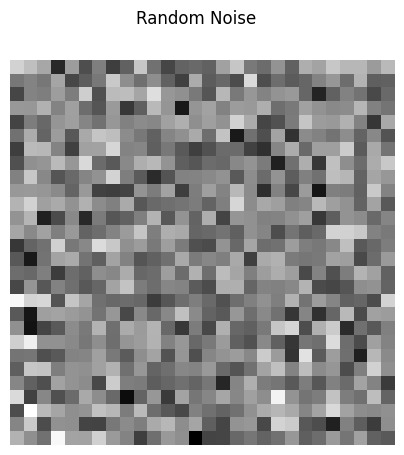

In [7]:
show_generations(noise, figsize=(5,5), title="Random Noise")

This is what a **random noise vector** looks like. It will be the **generators task** to convert this **noise vector** into an **actual image**. Keep one thing in mind, the **noise vector** will not exactly be **28 x 28 pixels**. It will be **1 x 28 pixels** for a **single image**. So really, **generating** an image from just a **noise vector** is **extremely tough task**.

---

Let's have a look at **generations**. When the generator is untrained.

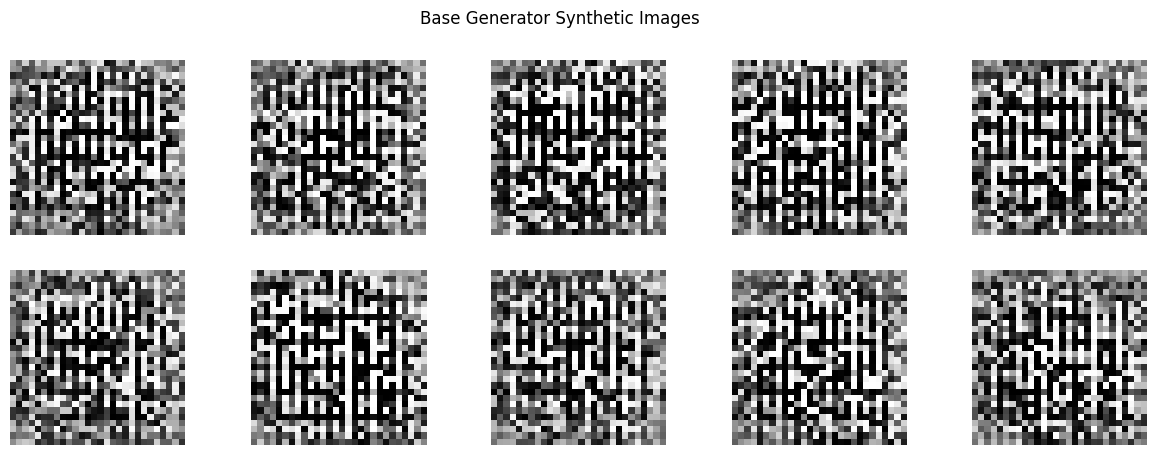

In [8]:
noise = generate_noise(10, device='cpu')
synthetic_images = Generator()(noise)

show_generations(
    synthetic_images, 2, 5,
    figsize=(15, 5),
    title="Base Generator Synthetic Images",
    save_loc = "./GeneratorImages/base_generations.png"
)


At this is stage when the **generator is not trained**, the **generations looks like some random noises**.

# **Discriminator Architecture 🔍**

The **Discriminator architecture** in a **Generative Adversarial Network** (GAN) serves as the **adversary to the generator**, **playing a critical role in distinguishing between real and generated data**. Typically implemented as a **convolutional neural network (CNN),** the **Discriminator** takes input in the form of **data samples** and aims to **classify them as either real or fake**.

Its layers consist of **convolutional and pooling operations** followed by **fully connected layers**, enabling it to learn **hierarchical representations** and **intricate features of the input data**.

In [9]:
class Discriminator(Module):
    def __init__(self, hdims:int =HDIM, img_channels:int=IMG_CHANNELS):
        """
        Initialize the Discriminator network.

        Args:
        - img_channels (int): Number of input channels (e.g., 1 for grayscale, 3 for RGB).
        - hdims (int): Number of channels in the first hidden layer.
        """
        super(Discriminator, self).__init__()

        self.disc = Sequential(
            self.discriminator_block(img_channels, hdims),
            self.discriminator_block(hdims, hdims * 2),
            self.discriminator_block(hdims * 2, 1, output_layer=True),
        )

    def discriminator_block(self, input_dims, output_dims, kernel_size=4, stride=2, output_layer=False):
        """
        Create a discriminator block.

        Args:
        - input_dims (int): Number of input channels.
        - output_dims (int): Number of output channels.
        - kernel_size (int): Size of the convolutional kernel.
        - stride (int): Stride for the convolution operation.
        - output_layer (bool, optional): If True, only spectral normalization is applied, else batch normalization and LeakyReLU are added.

        Returns:
        - Sequential: A discriminator block.
        """
        if output_layer:
            return Sequential(
                spectral_norm(Conv2d(input_dims, output_dims, kernel_size, stride))
            )
        else:
            return Sequential(
                spectral_norm(Conv2d(input_dims, output_dims, kernel_size, stride)),
                BatchNorm2d(output_dims),
                LeakyReLU(0.2, inplace=True)
            )

    def forward(self, image):
        """
        Forward pass of the Discriminator network.

        Args:
        - image (torch.Tensor): The input image.

        Returns:
        - torch.Tensor: The discriminator's prediction.
        """
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)


# **SN-GAN Architecture 👦**

The building blocks of are GAN are ready. Now it's time to combine these building blocks to make up the final architecture.

In [10]:
# Initialize the generator
generator = Generator().to(DEVICE)

# Initialize generator optimizer
generator_optim = torch.optim.Adam(params = generator.parameters(), lr = LR, betas = (beta_1, beta_2))

# Initialize the discriminator
discriminator = Discriminator().to(DEVICE)

# Initialize discriminator optimizer
discriminator_optim = torch.optim.Adam(params = discriminator.parameters(), lr = LR, betas = (beta_1, beta_2))

In [11]:
# Normalize the weights of generator and discriminator
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

generator = generator.apply(weights_init)
discriminator = discriminator.apply(weights_init)

Finally, everything is on in the right place. Other than a single thing the data set. It's time to load the data set.

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(".", download=True, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.09MB/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.26MB/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



# **SN-GAN Training 🌿**

Now it's time to combine everything and build up the training process.

 13%|█▎        | 497/3750 [00:11<01:08, 47.33it/s]

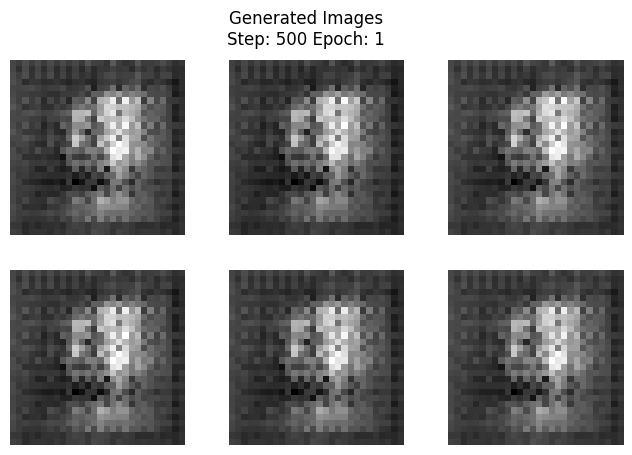

 27%|██▋       | 999/3750 [00:24<01:18, 34.87it/s]

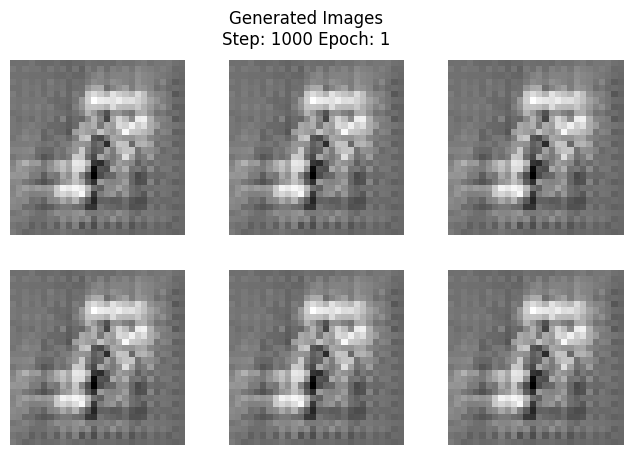

 40%|███▉      | 1495/3750 [00:35<00:50, 44.55it/s]

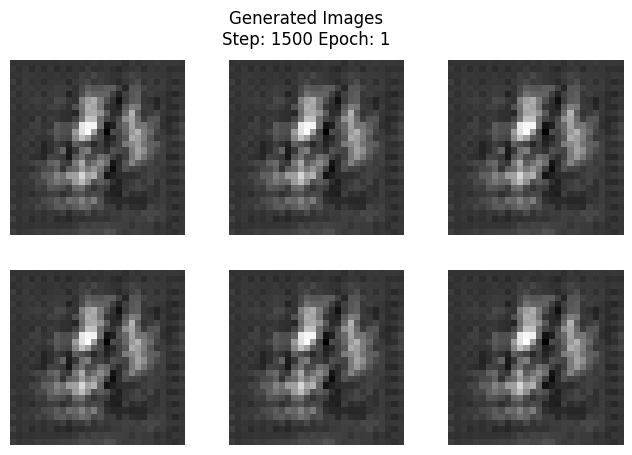

 53%|█████▎    | 1995/3750 [00:47<00:39, 44.43it/s]

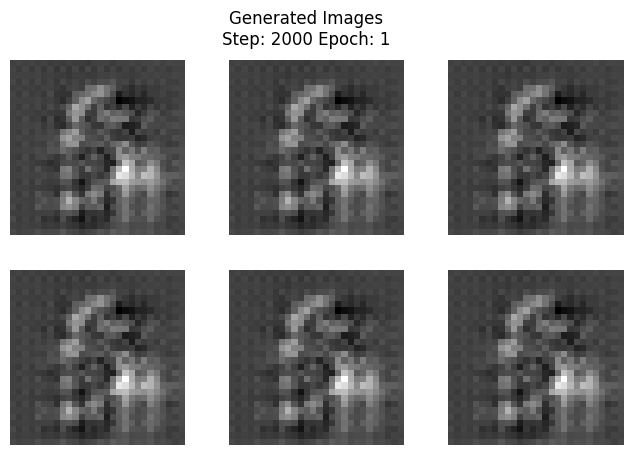

 67%|██████▋   | 2495/3750 [00:58<00:27, 45.24it/s]

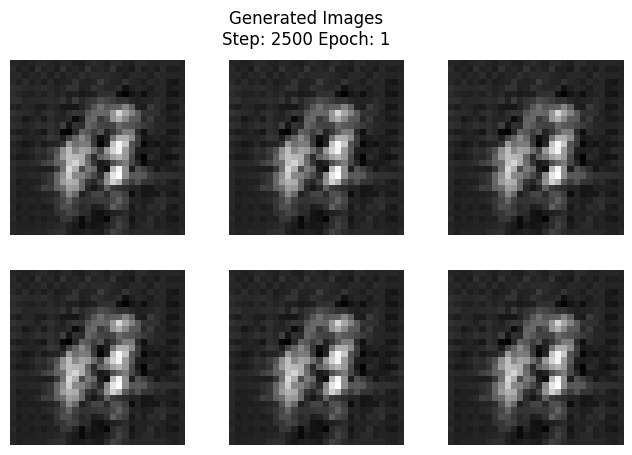

 80%|███████▉  | 2999/3750 [01:10<00:17, 43.08it/s]

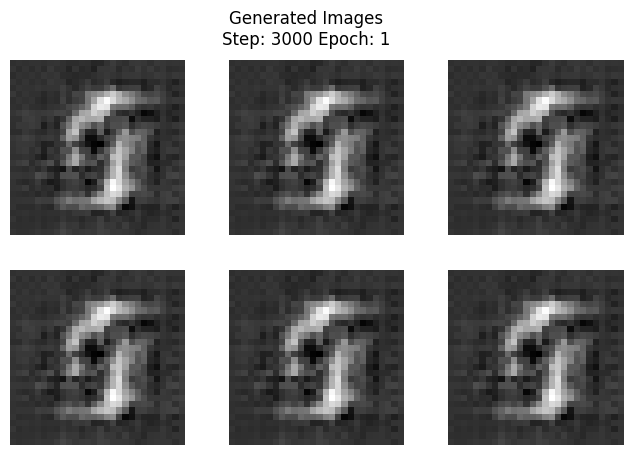

 93%|█████████▎| 3497/3750 [01:21<00:05, 47.16it/s]

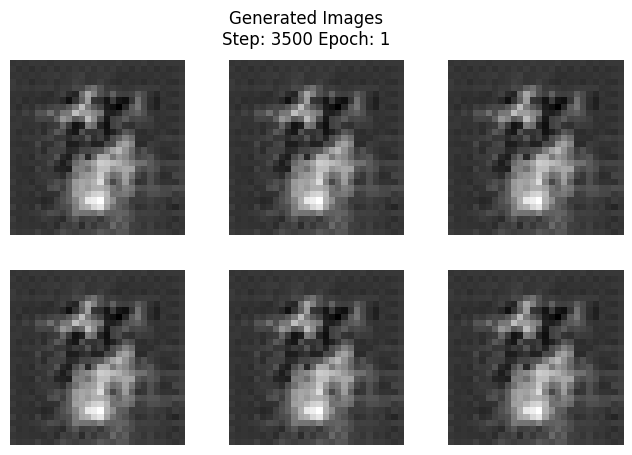

 13%|█▎        | 497/3750 [00:11<01:11, 45.42it/s]

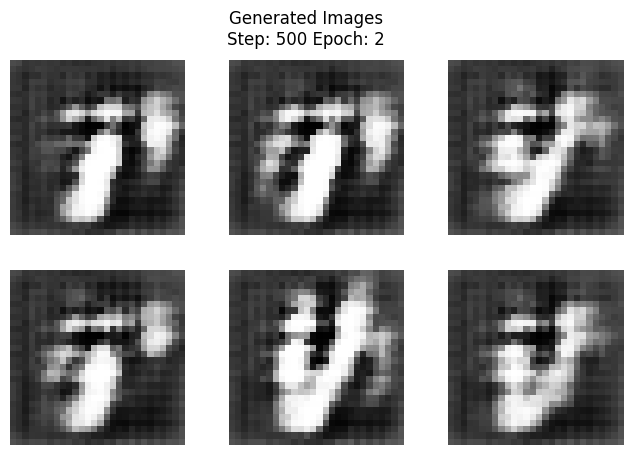

 27%|██▋       | 999/3750 [00:22<01:01, 44.82it/s]

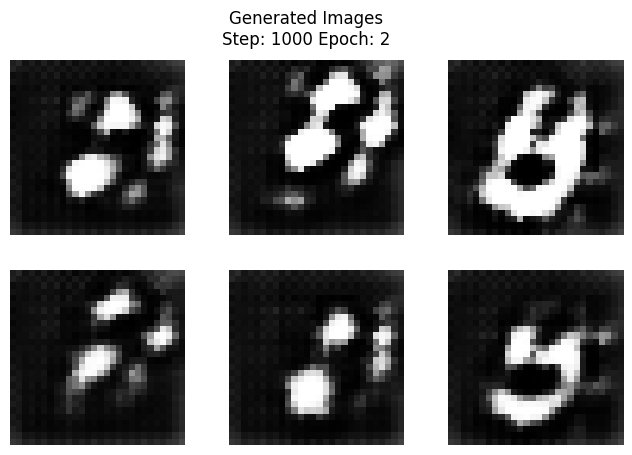

 40%|███▉      | 1499/3750 [00:34<00:50, 44.63it/s]

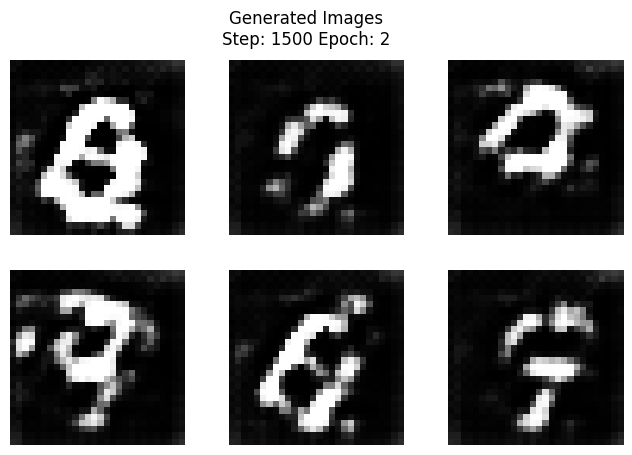

 53%|█████▎    | 1995/3750 [00:45<00:36, 47.83it/s]

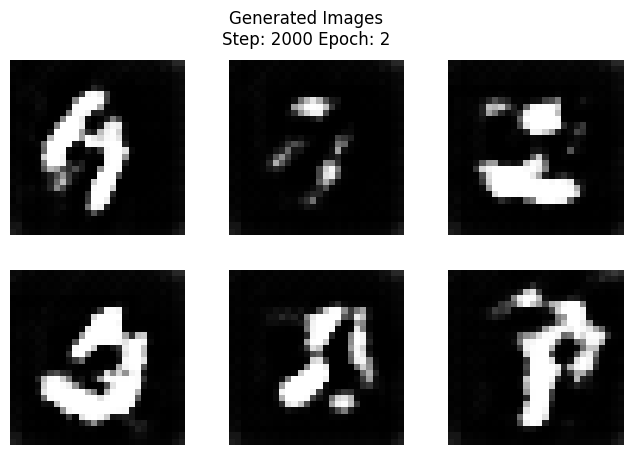

 67%|██████▋   | 2498/3750 [00:57<00:37, 33.22it/s]

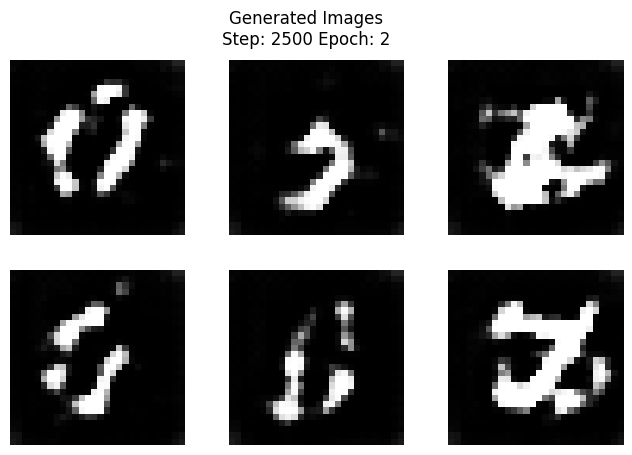

 80%|███████▉  | 2998/3750 [01:08<00:16, 46.05it/s]

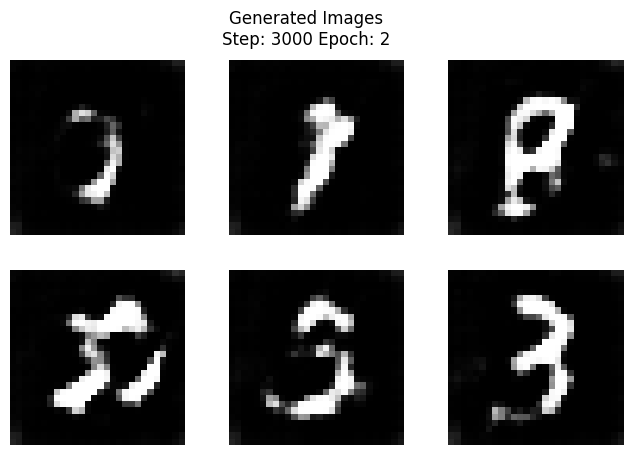

 93%|█████████▎| 3499/3750 [01:20<00:05, 45.37it/s]

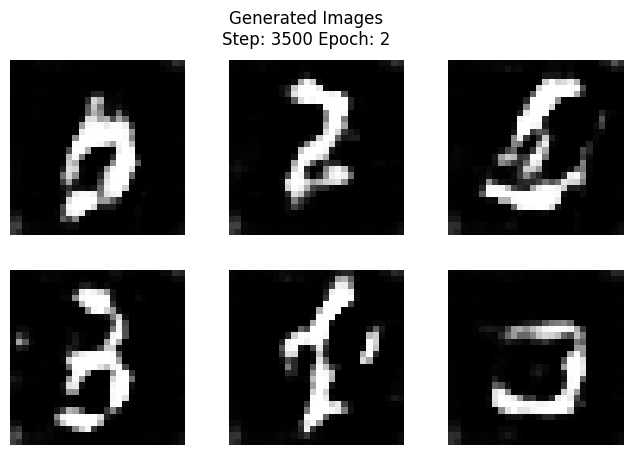

 13%|█▎        | 499/3750 [00:11<01:12, 44.69it/s]

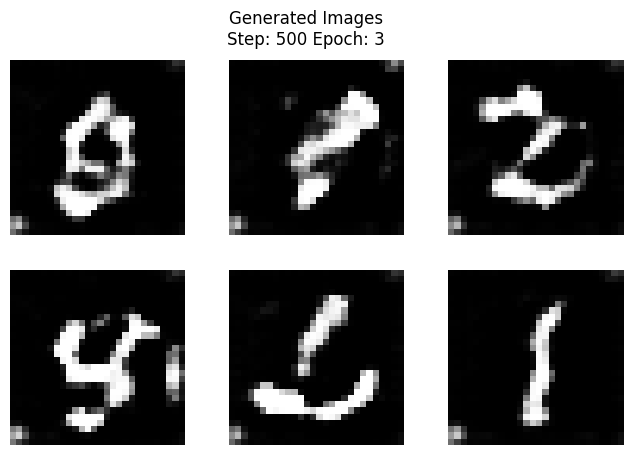

 27%|██▋       | 996/3750 [00:23<00:58, 47.14it/s]

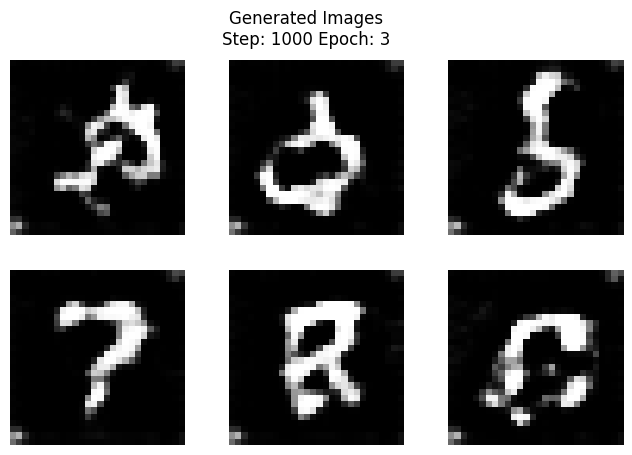

 40%|███▉      | 1496/3750 [00:34<00:49, 45.52it/s]

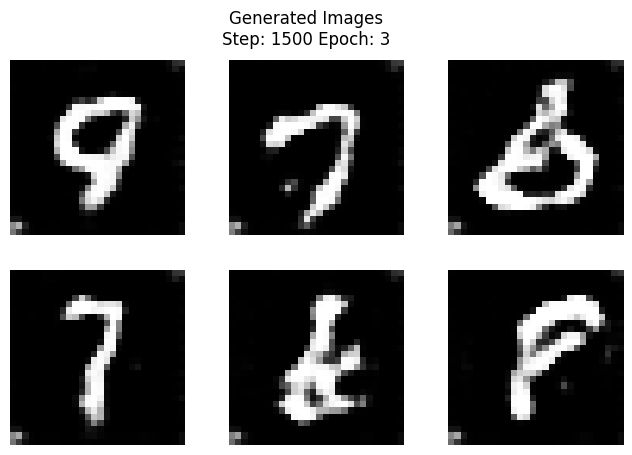

 53%|█████▎    | 1996/3750 [00:45<00:38, 46.14it/s]

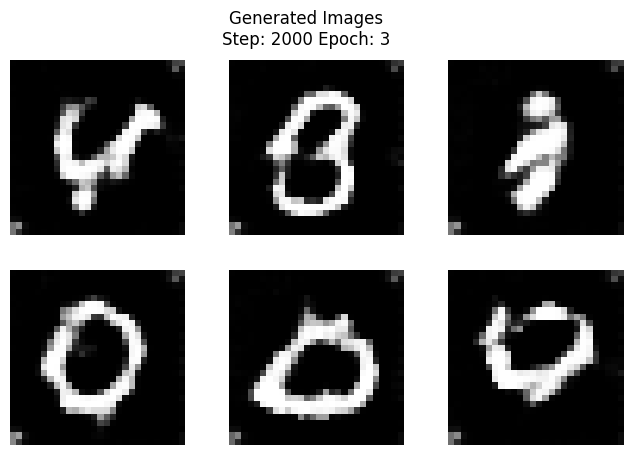

 67%|██████▋   | 2497/3750 [00:58<00:35, 35.27it/s]

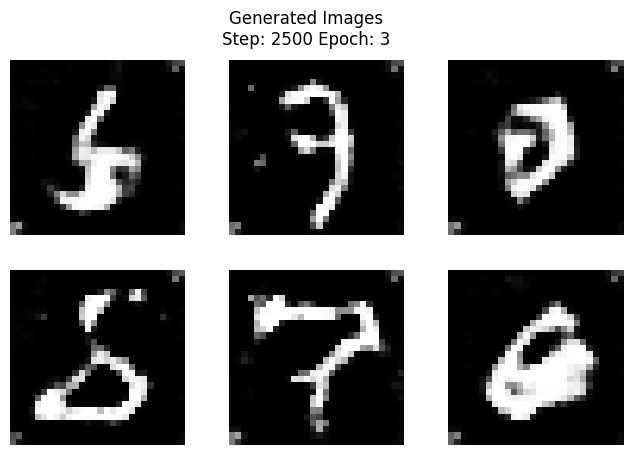

 80%|███████▉  | 2997/3750 [01:10<00:17, 42.41it/s]

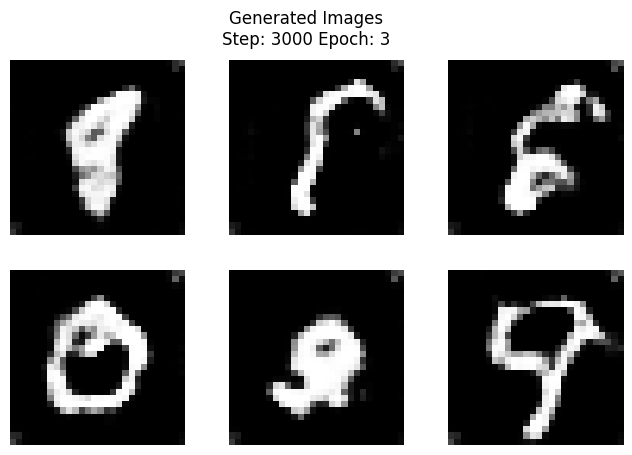

 93%|█████████▎| 3495/3750 [01:21<00:05, 47.03it/s]

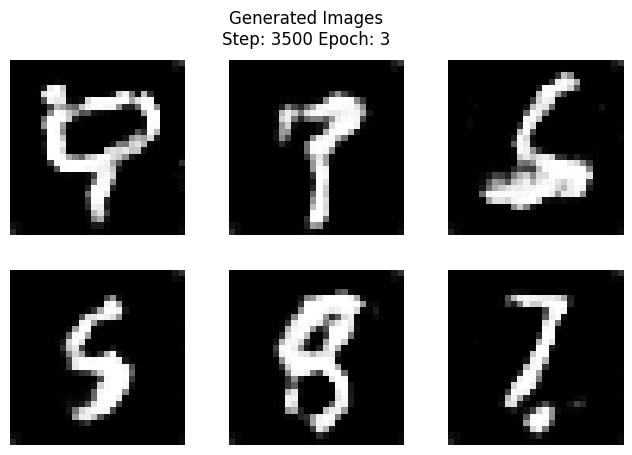

 13%|█▎        | 497/3750 [00:11<01:13, 44.40it/s]

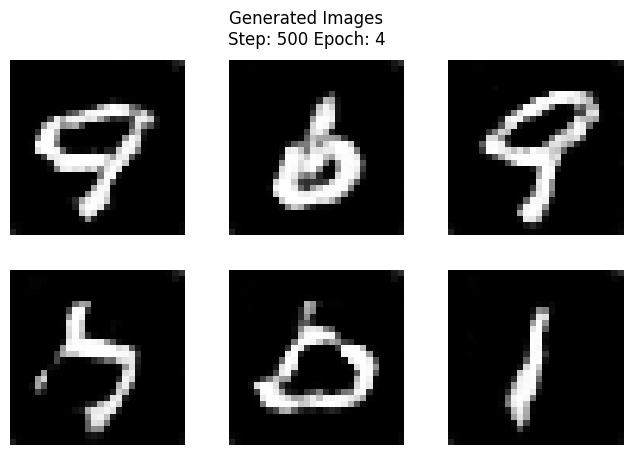

 27%|██▋       | 997/3750 [00:22<01:06, 41.12it/s]

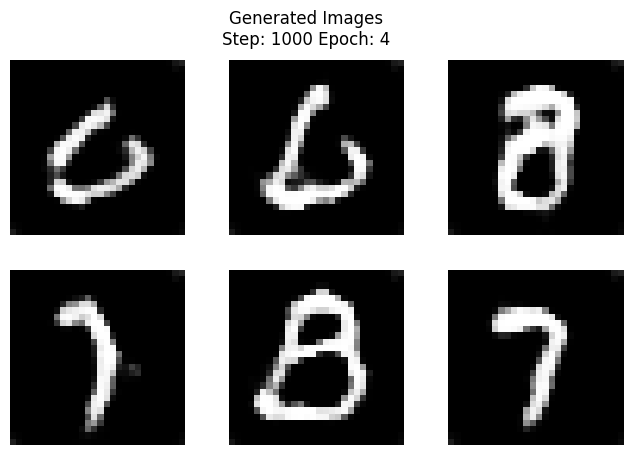

 40%|███▉      | 1499/3750 [00:34<01:05, 34.63it/s]

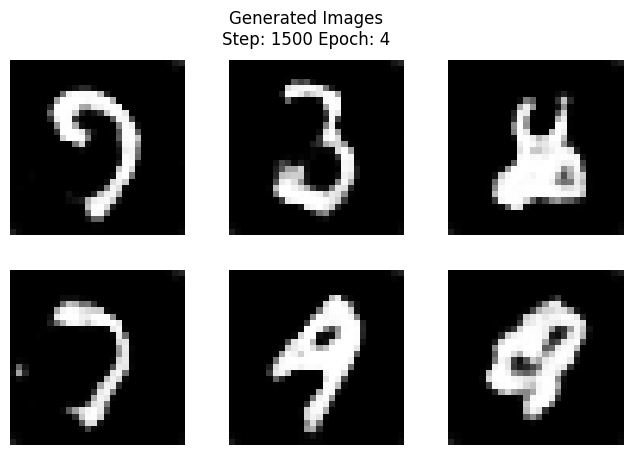

 53%|█████▎    | 1995/3750 [00:46<00:37, 46.92it/s]

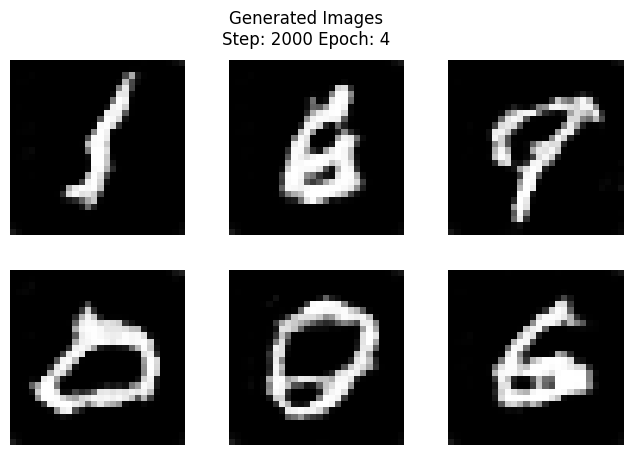

 67%|██████▋   | 2495/3750 [00:57<00:27, 46.01it/s]

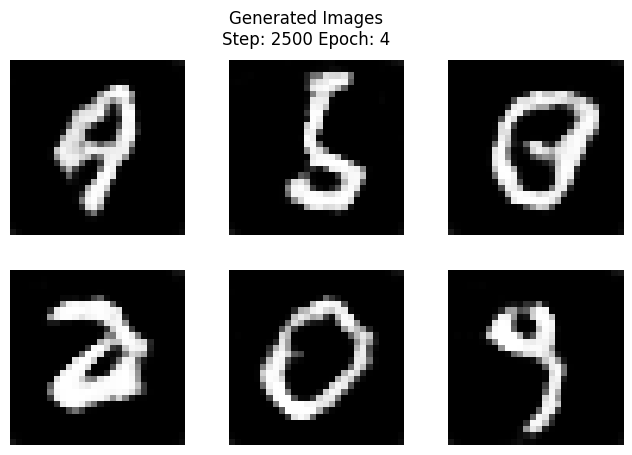

 80%|███████▉  | 2996/3750 [01:09<00:17, 42.32it/s]

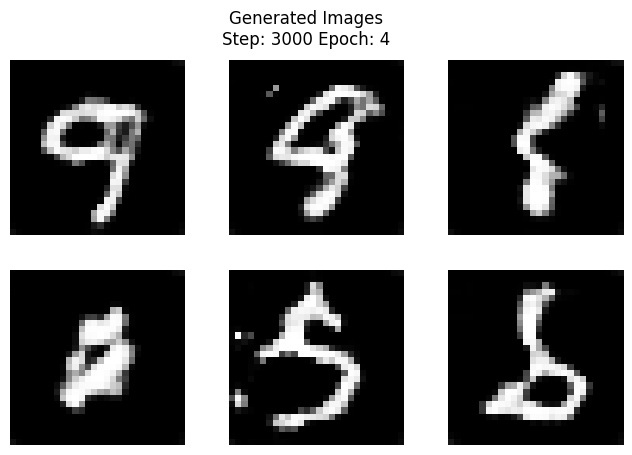

 93%|█████████▎| 3499/3750 [01:20<00:05, 46.13it/s]

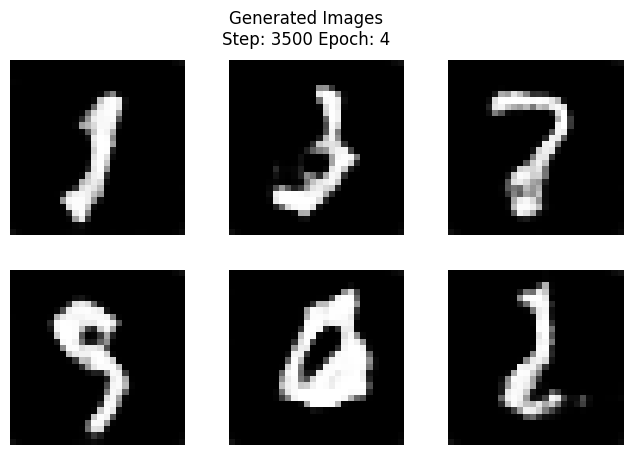

 13%|█▎        | 498/3750 [00:10<01:09, 46.85it/s]

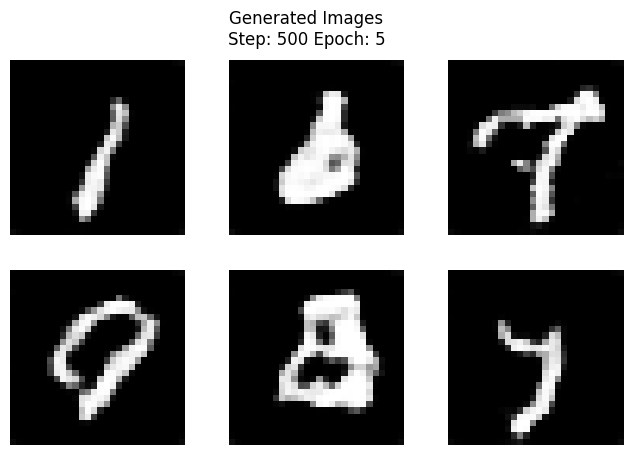

 27%|██▋       | 995/3750 [00:22<01:02, 44.19it/s]

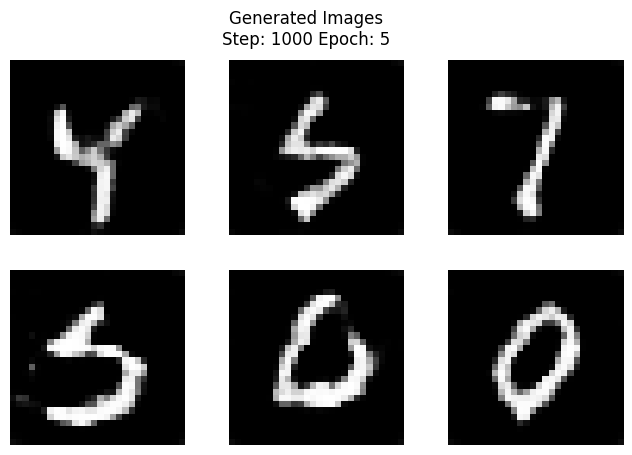

 40%|███▉      | 1495/3750 [00:34<00:56, 40.16it/s]

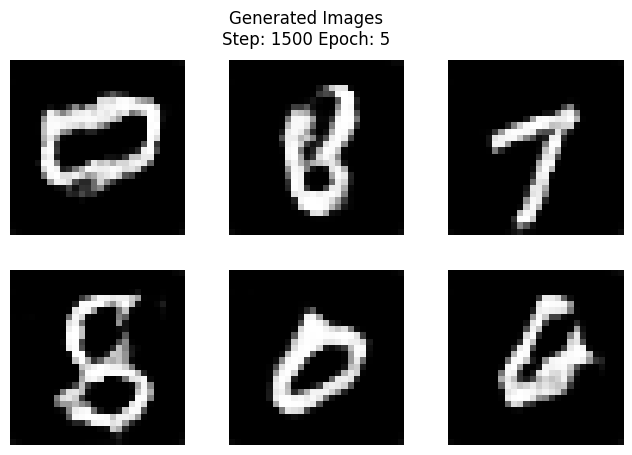

 53%|█████▎    | 1997/3750 [00:47<00:41, 41.92it/s]

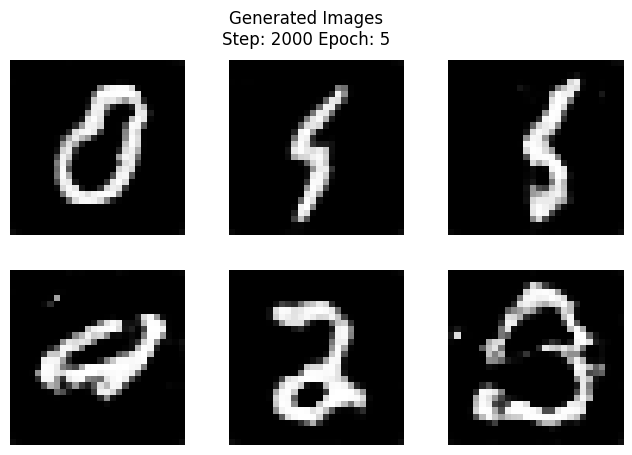

 67%|██████▋   | 2495/3750 [01:00<00:34, 35.92it/s]

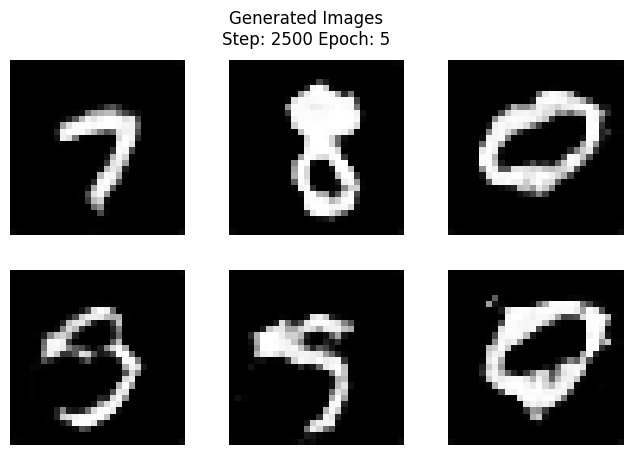

 80%|███████▉  | 2997/3750 [01:15<00:18, 39.65it/s]

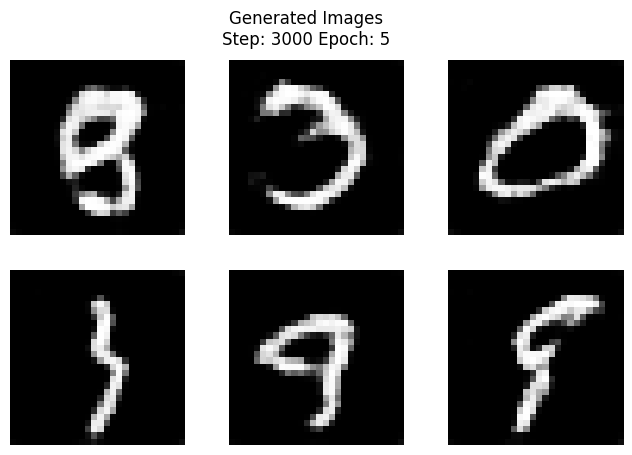

 93%|█████████▎| 3499/3750 [01:30<00:07, 34.26it/s]

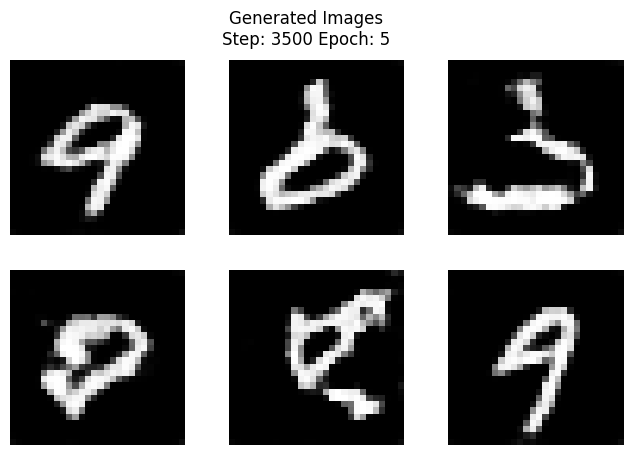

 13%|█▎        | 499/3750 [00:14<01:37, 33.51it/s]

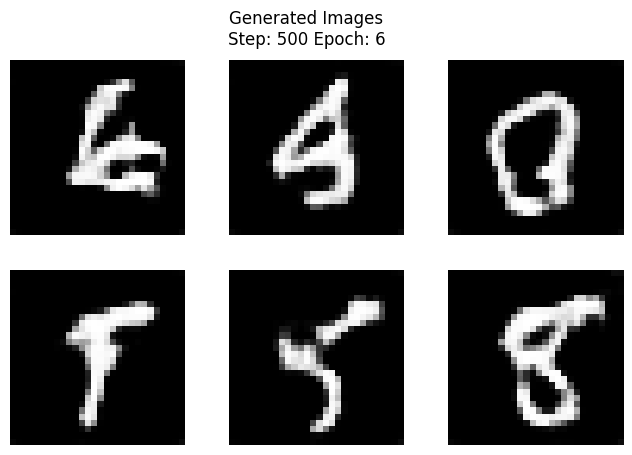

 27%|██▋       | 998/3750 [00:28<01:20, 34.30it/s]

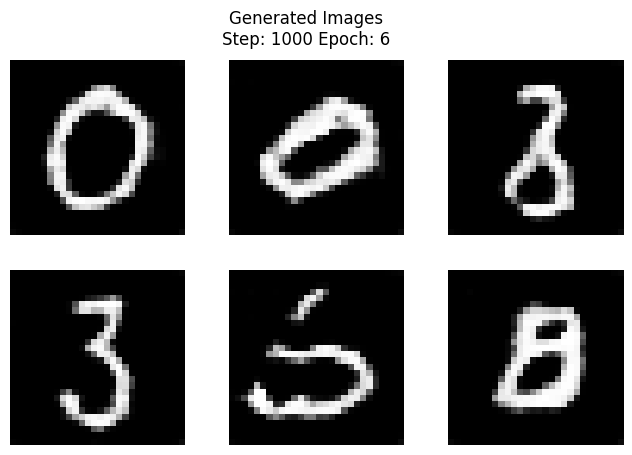

 40%|███▉      | 1495/3750 [00:42<00:56, 40.02it/s]

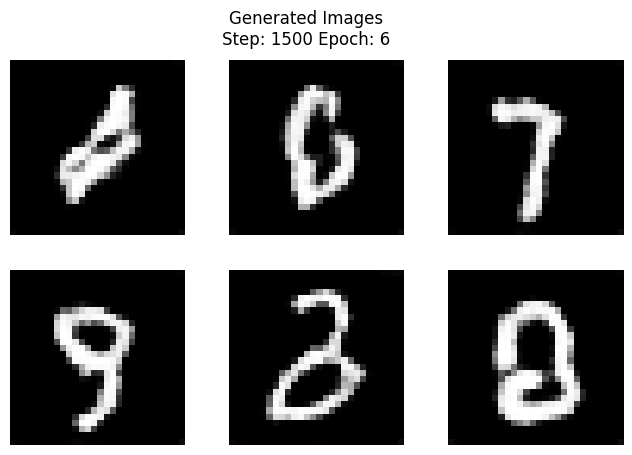

 53%|█████▎    | 1995/3750 [00:55<00:42, 41.70it/s]

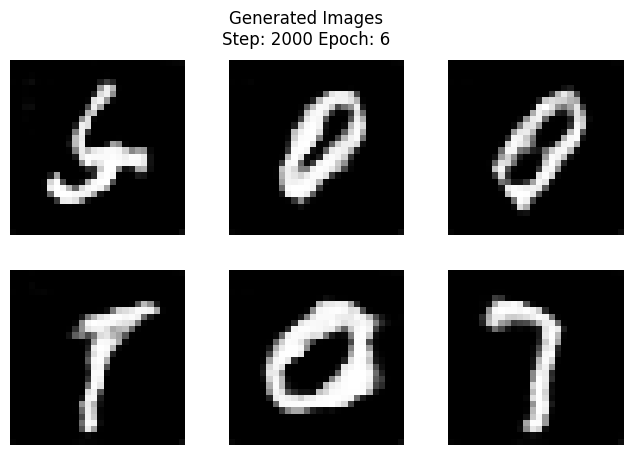

 67%|██████▋   | 2499/3750 [01:06<00:28, 43.59it/s]

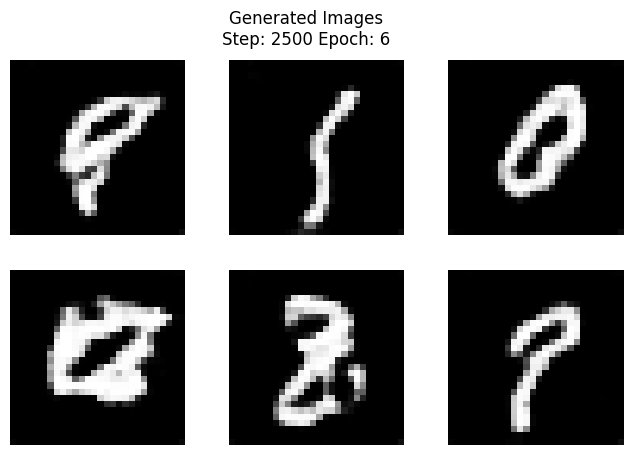

 80%|███████▉  | 2996/3750 [01:18<00:18, 41.60it/s]

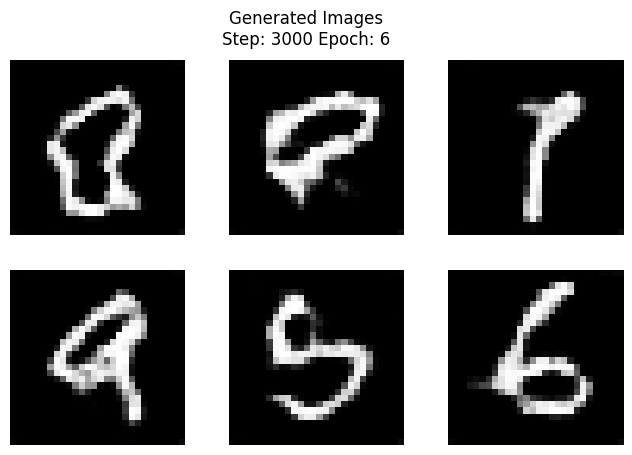

 93%|█████████▎| 3499/3750 [01:29<00:07, 35.56it/s]

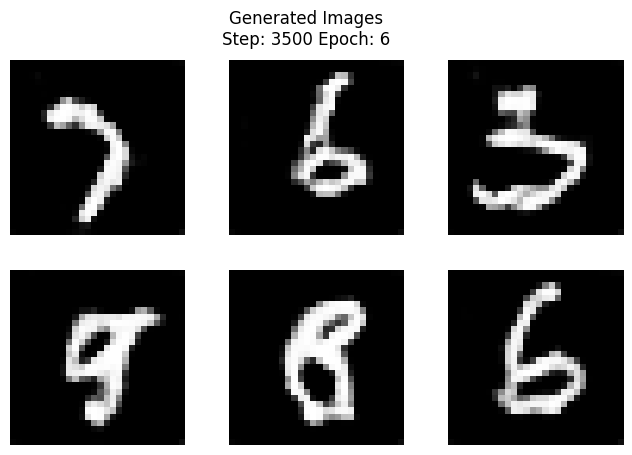

 13%|█▎        | 498/3750 [00:11<01:15, 42.97it/s]

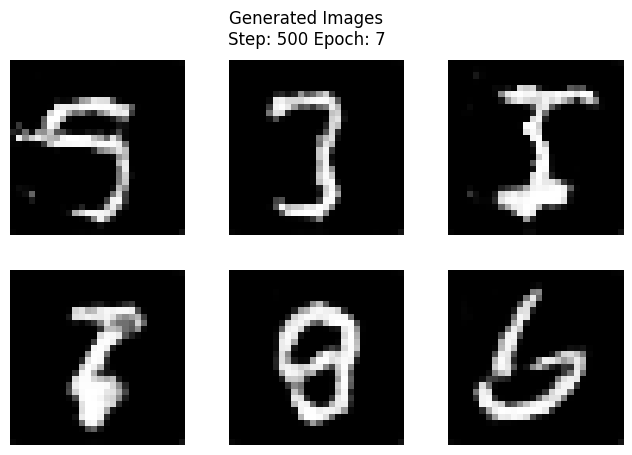

 27%|██▋       | 998/3750 [00:22<01:02, 43.86it/s]

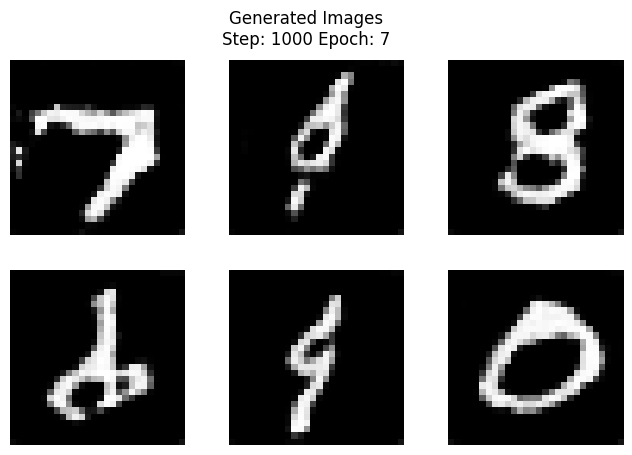

 40%|███▉      | 1495/3750 [00:33<00:47, 47.25it/s]

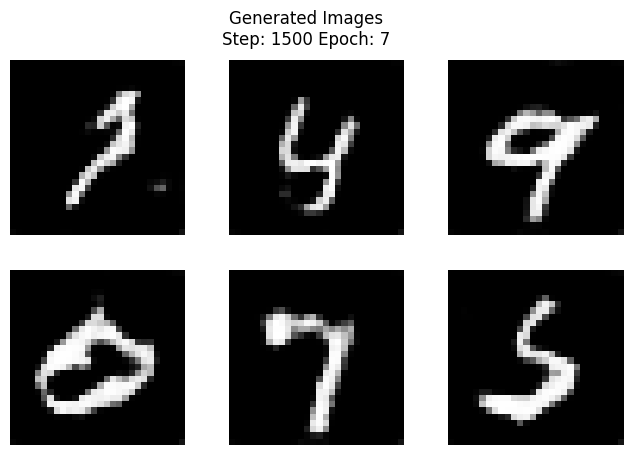

 53%|█████▎    | 1996/3750 [00:44<00:37, 47.05it/s]

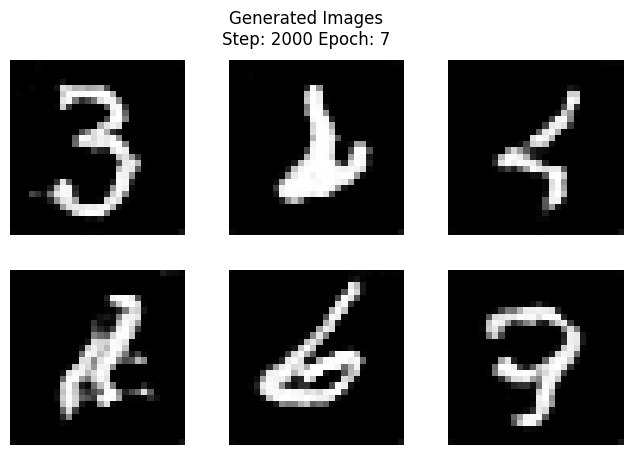

 67%|██████▋   | 2498/3750 [00:56<00:32, 38.62it/s]

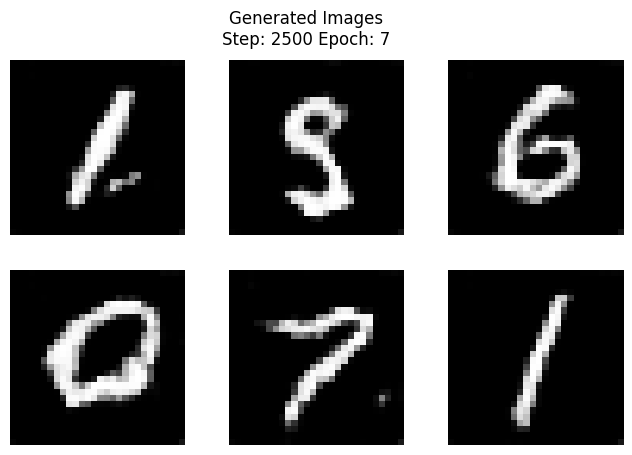

 80%|███████▉  | 2997/3750 [01:07<00:16, 46.95it/s]

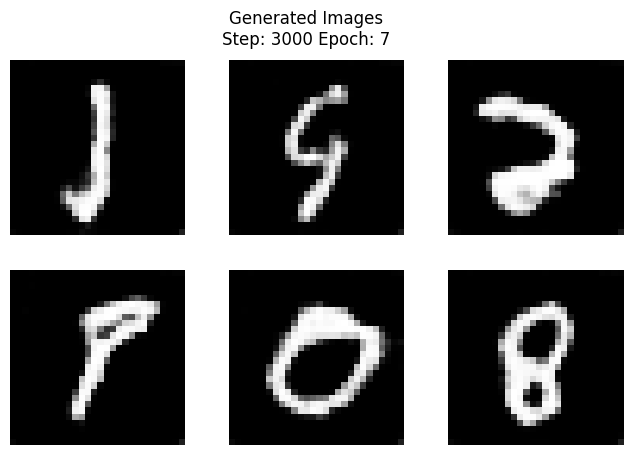

 93%|█████████▎| 3497/3750 [01:18<00:05, 45.18it/s]

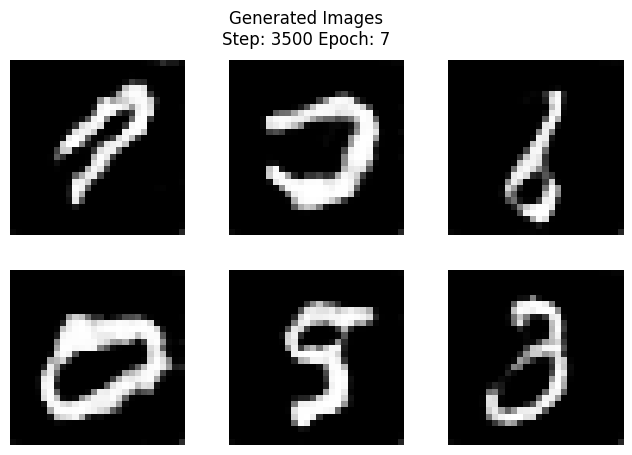

 13%|█▎        | 495/3750 [00:13<01:19, 40.70it/s]

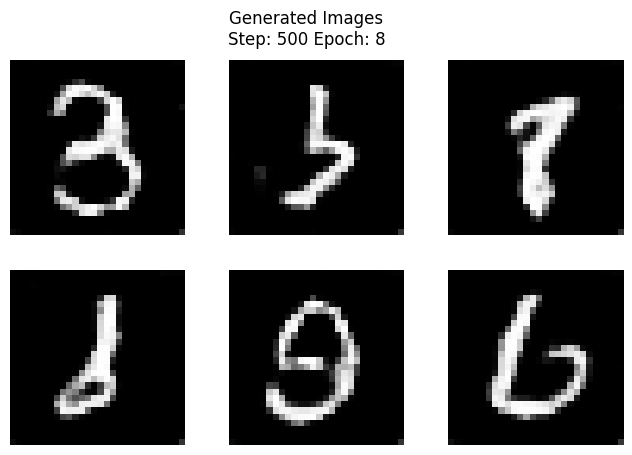

 27%|██▋       | 998/3750 [00:25<01:08, 40.11it/s]

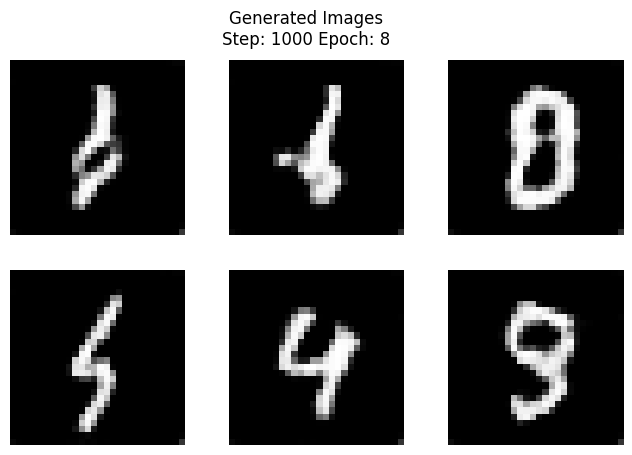

 40%|███▉      | 1495/3750 [00:37<00:49, 45.26it/s]

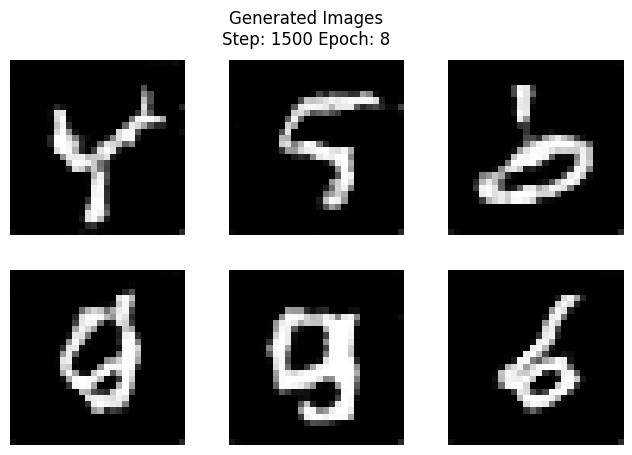

 53%|█████▎    | 1995/3750 [00:49<00:43, 40.81it/s]

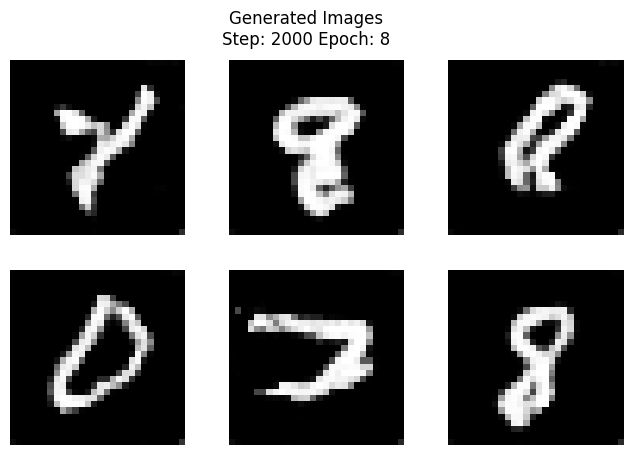

 67%|██████▋   | 2495/3750 [01:01<00:27, 45.28it/s]

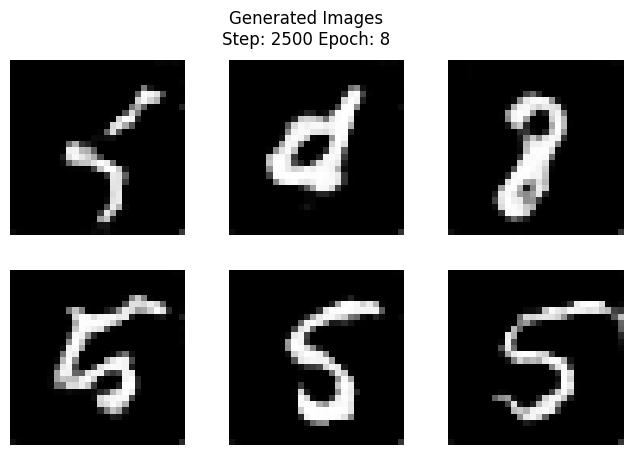

 80%|███████▉  | 2996/3750 [01:13<00:17, 44.24it/s]

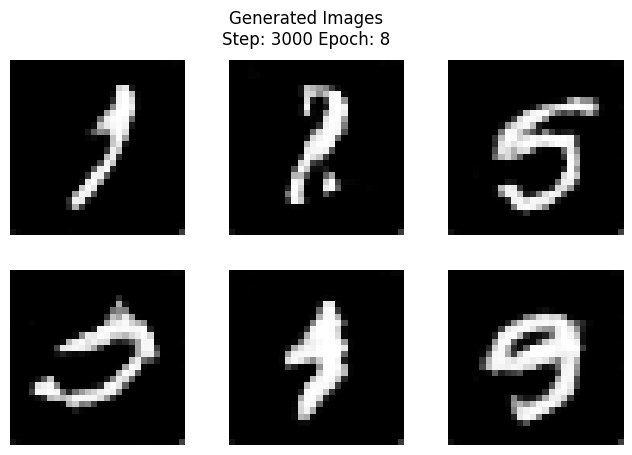

 93%|█████████▎| 3498/3750 [01:25<00:06, 40.80it/s]

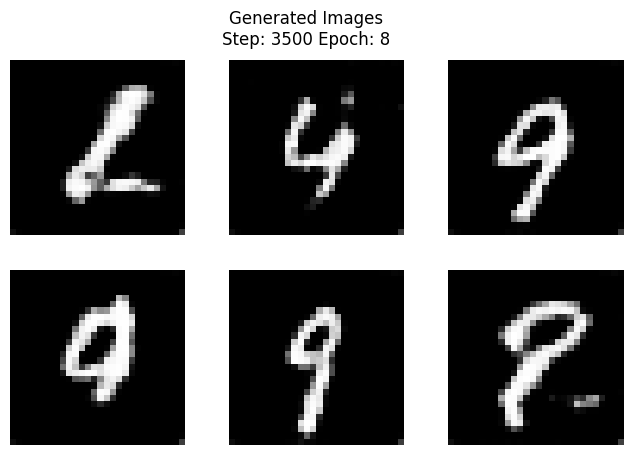

 13%|█▎        | 496/3750 [00:12<01:40, 32.27it/s]

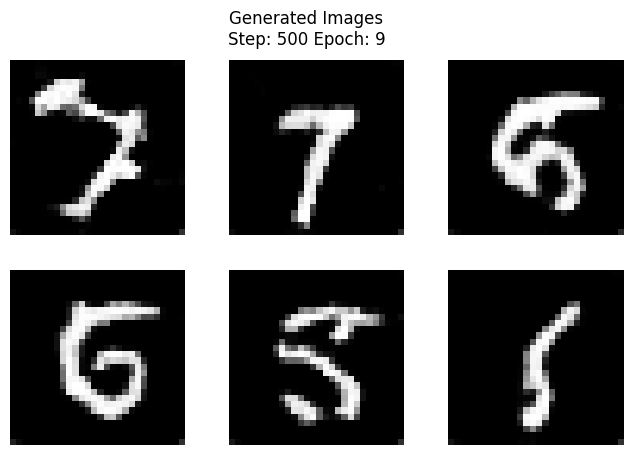

 27%|██▋       | 996/3750 [00:24<01:00, 45.41it/s]

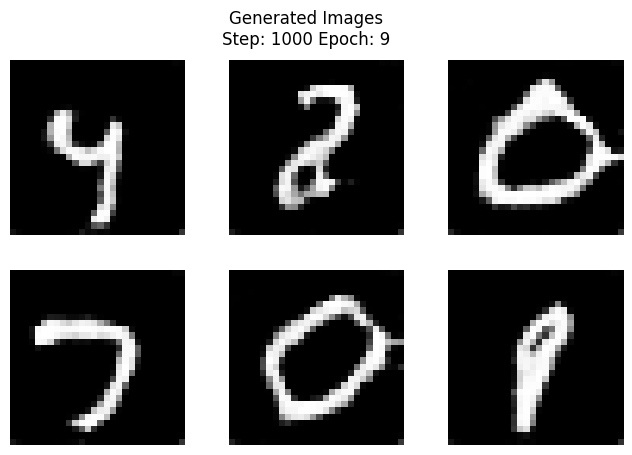

 40%|███▉      | 1497/3750 [00:36<00:52, 43.30it/s]

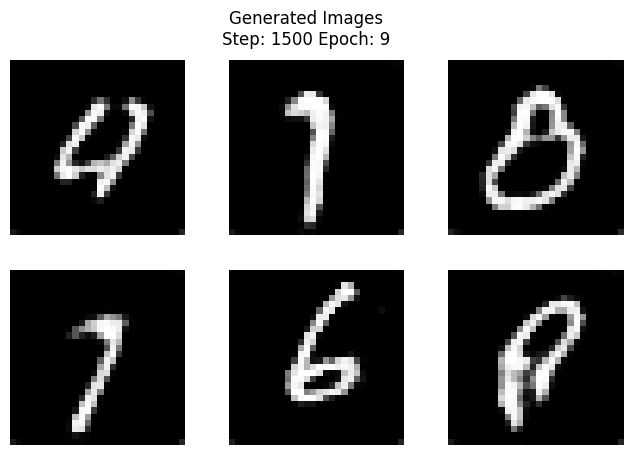

 53%|█████▎    | 1997/3750 [00:48<00:40, 43.64it/s]

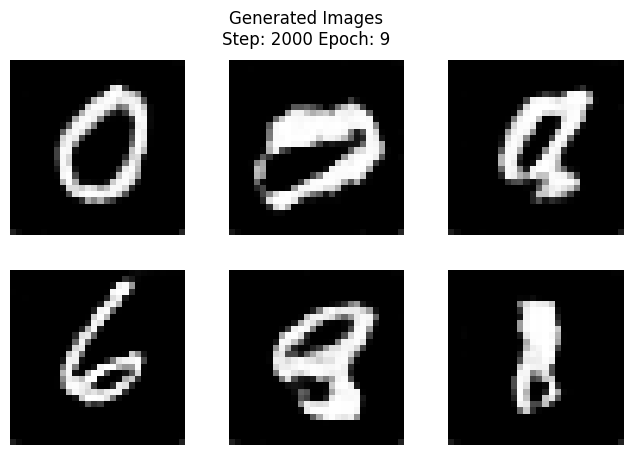

 67%|██████▋   | 2499/3750 [01:01<00:30, 41.34it/s]

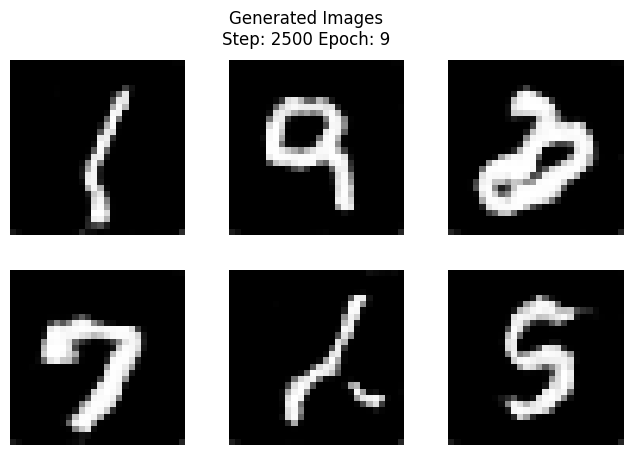

 80%|███████▉  | 2998/3750 [01:13<00:16, 46.72it/s]

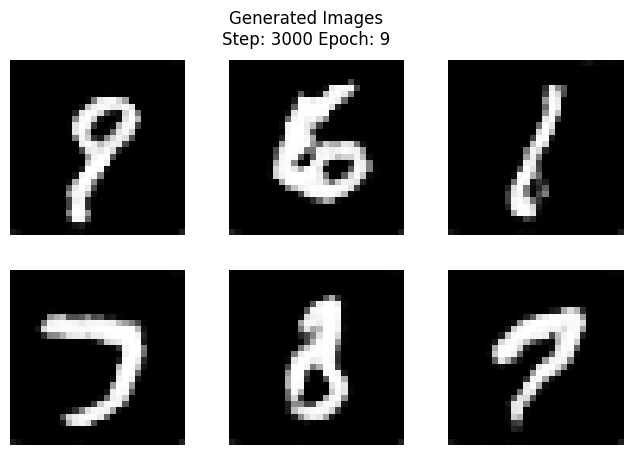

 93%|█████████▎| 3497/3750 [01:25<00:05, 42.66it/s]

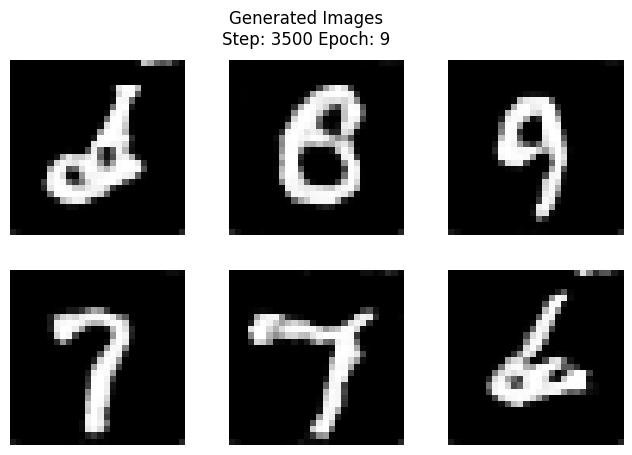

 13%|█▎        | 497/3750 [00:11<01:11, 45.67it/s]

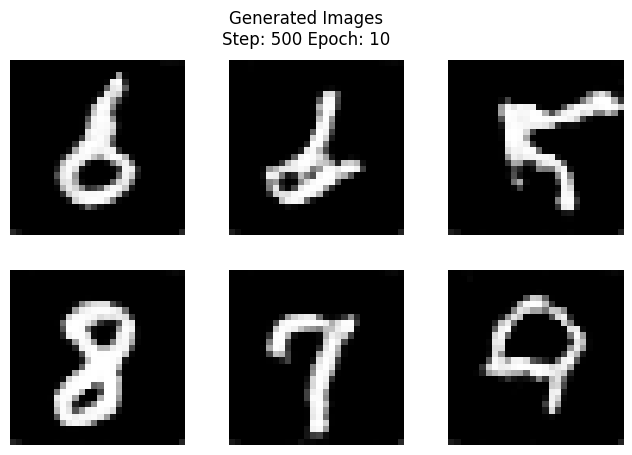

 27%|██▋       | 997/3750 [00:23<01:15, 36.44it/s]

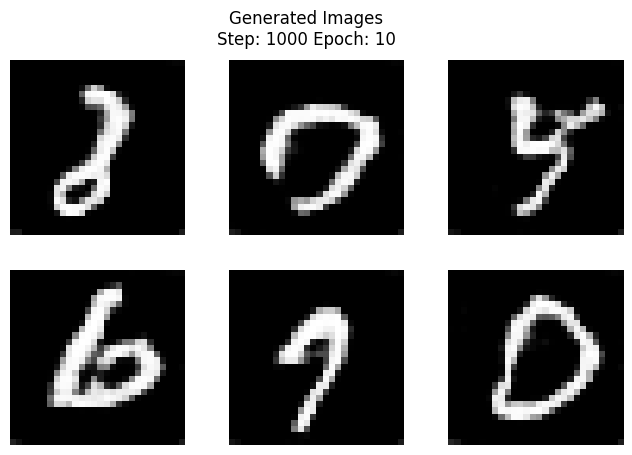

 40%|███▉      | 1499/3750 [00:36<00:50, 44.25it/s]

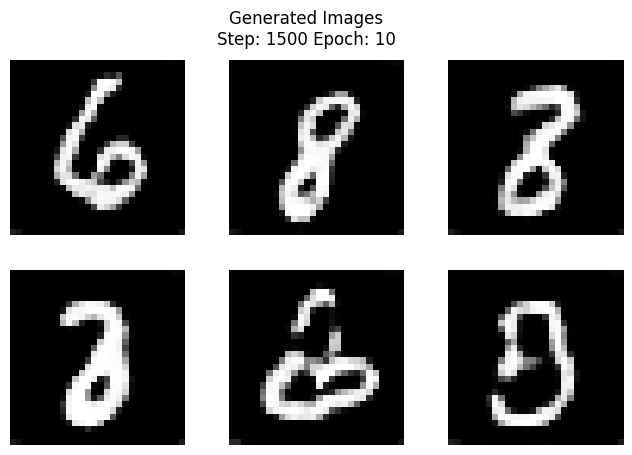

 53%|█████▎    | 1997/3750 [00:48<00:44, 39.70it/s]

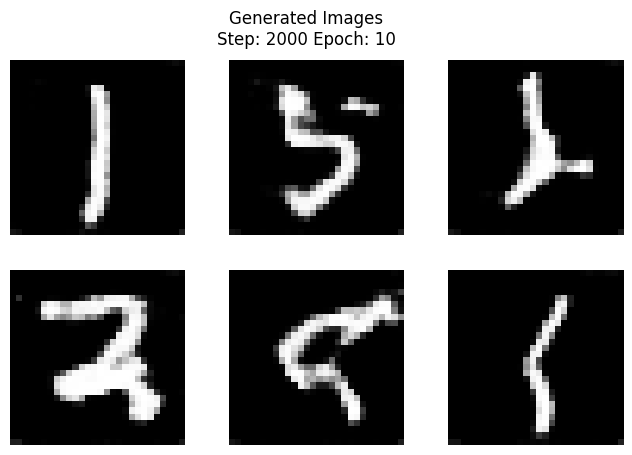

 67%|██████▋   | 2499/3750 [01:01<00:28, 44.35it/s]

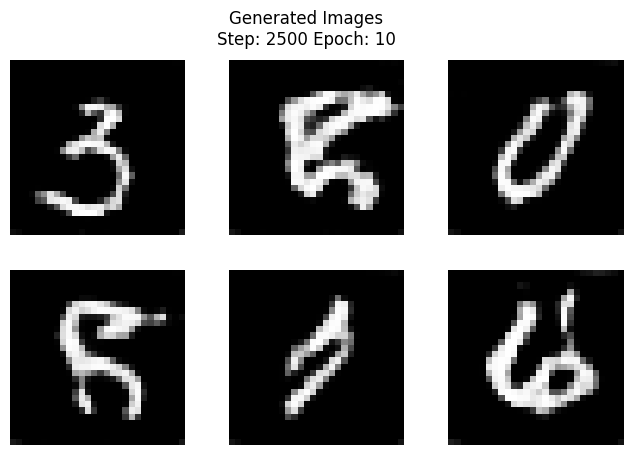

 80%|███████▉  | 2996/3750 [01:13<00:18, 41.40it/s]

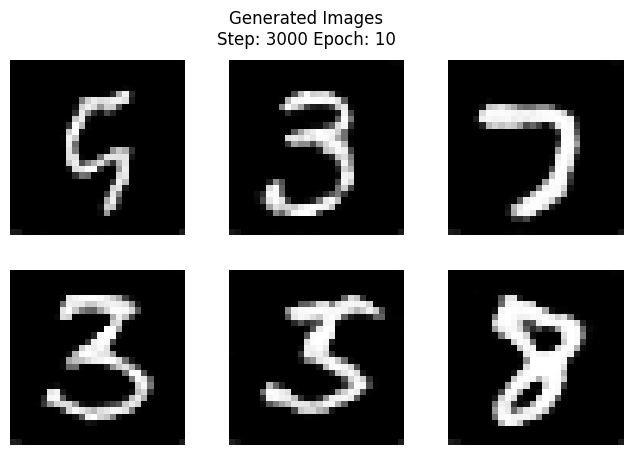

 93%|█████████▎| 3496/3750 [01:26<00:06, 41.58it/s]

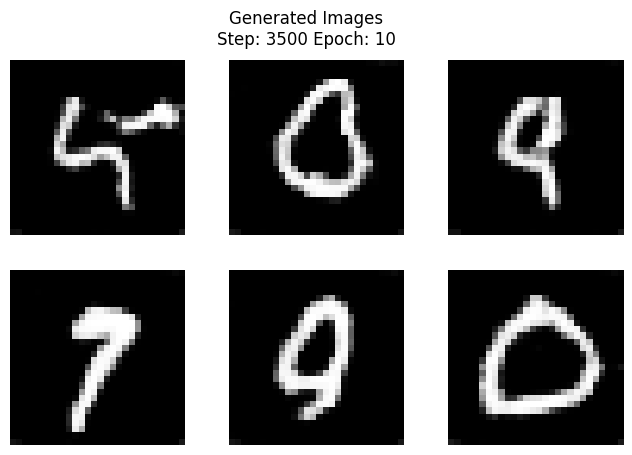

 13%|█▎        | 498/3750 [00:11<01:14, 43.68it/s]

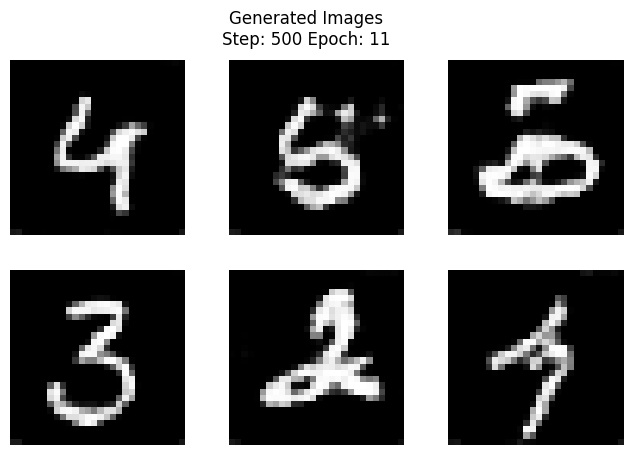

 27%|██▋       | 999/3750 [00:24<01:06, 41.13it/s]

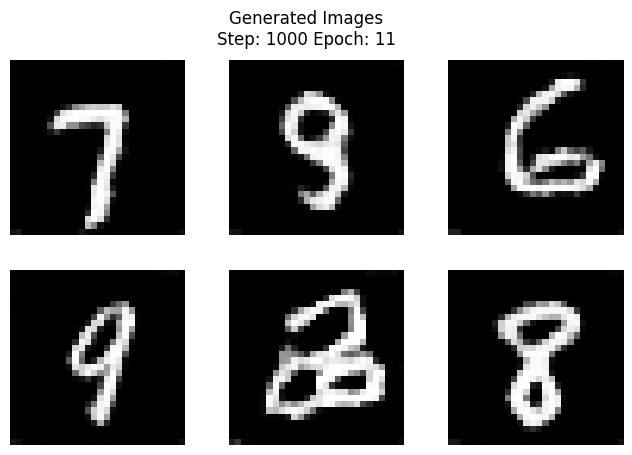

 40%|███▉      | 1499/3750 [00:36<00:53, 42.26it/s]

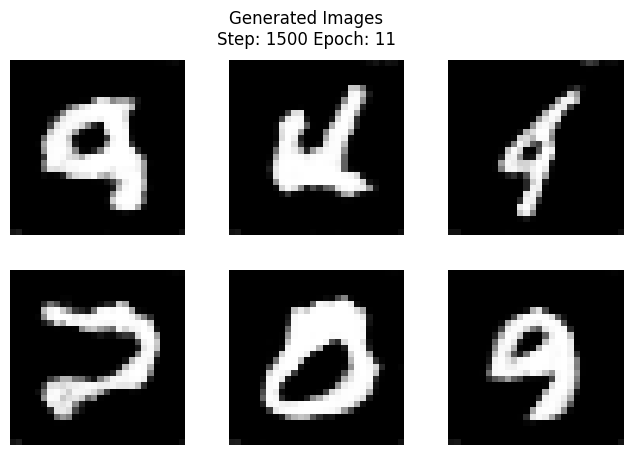

 53%|█████▎    | 1997/3750 [00:48<00:39, 44.39it/s]

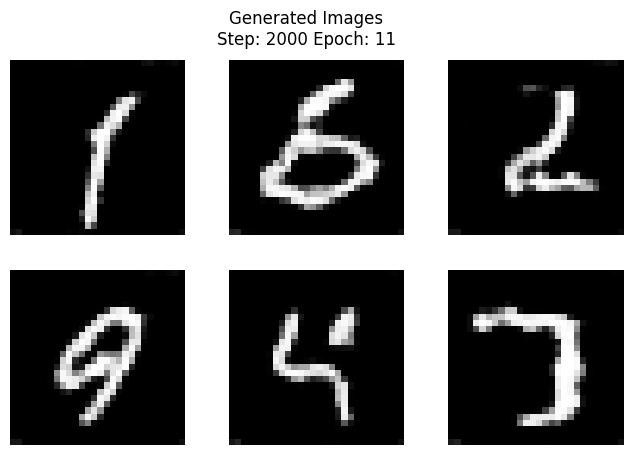

 67%|██████▋   | 2495/3750 [01:00<00:30, 41.06it/s]

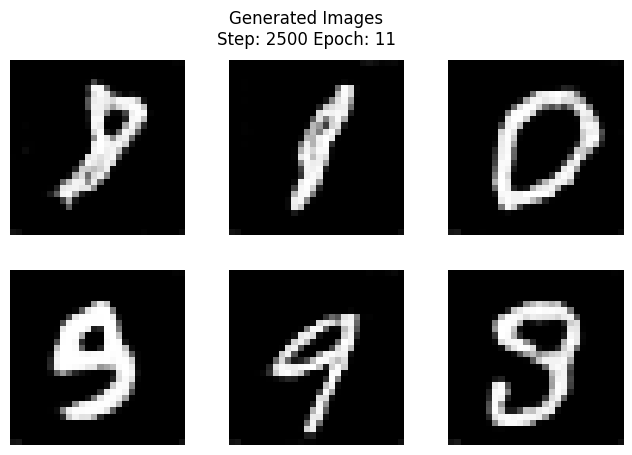

 80%|███████▉  | 2996/3750 [01:12<00:18, 41.37it/s]

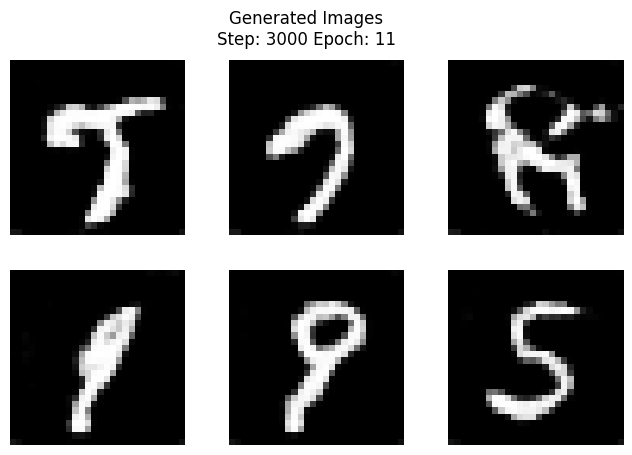

 93%|█████████▎| 3499/3750 [01:24<00:05, 45.70it/s]

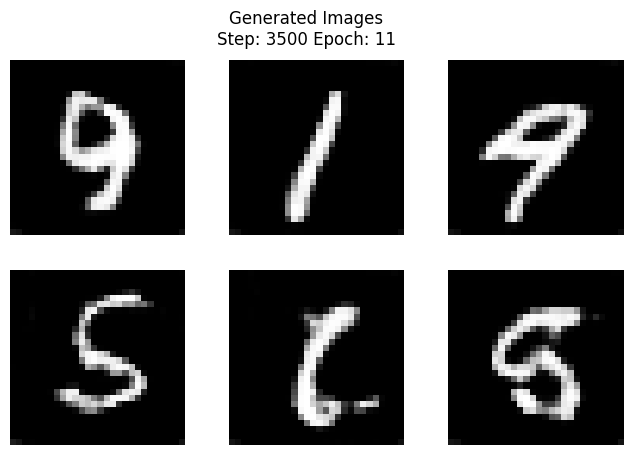

 13%|█▎        | 499/3750 [00:12<01:16, 42.41it/s]

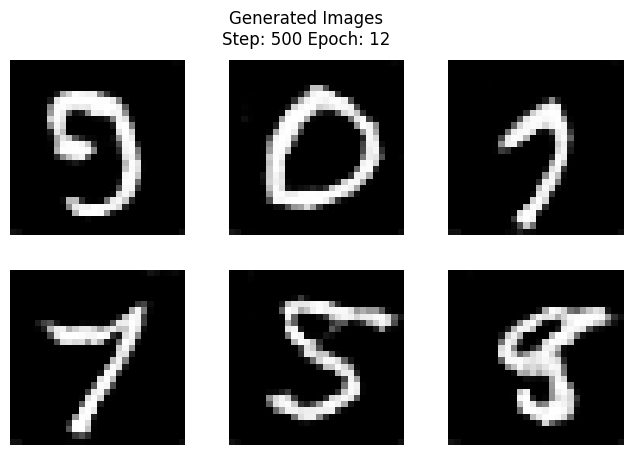

 27%|██▋       | 997/3750 [00:24<01:00, 45.38it/s]

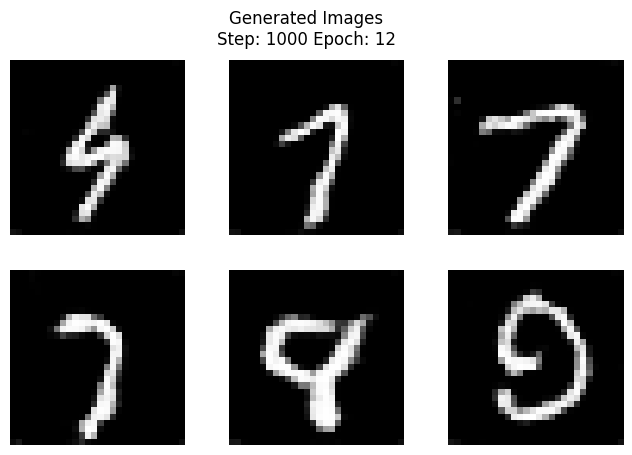

 40%|███▉      | 1497/3750 [00:36<00:49, 45.18it/s]

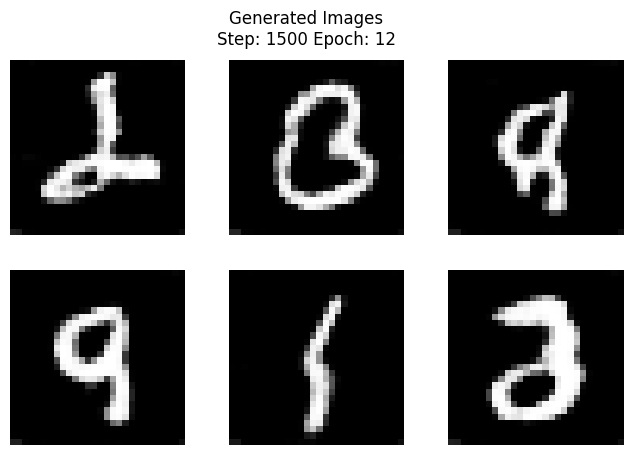

 53%|█████▎    | 1997/3750 [00:48<00:40, 43.78it/s]

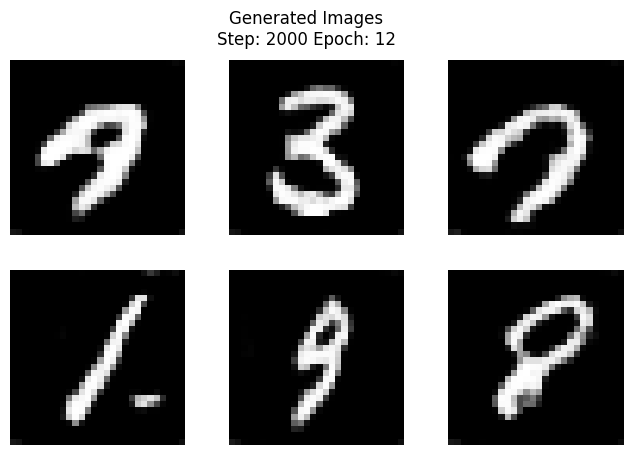

 67%|██████▋   | 2495/3750 [01:00<00:28, 43.29it/s]

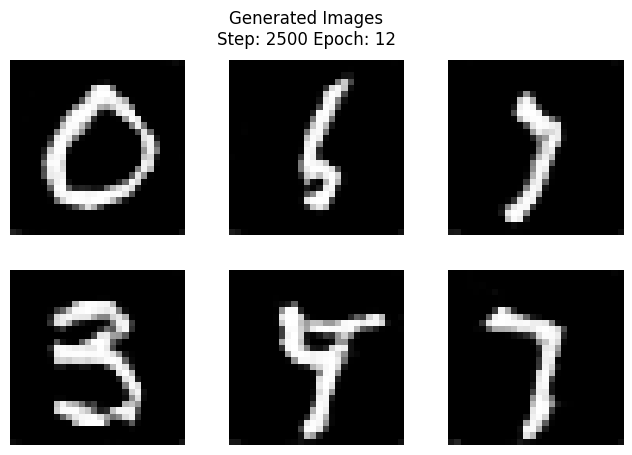

 80%|███████▉  | 2999/3750 [01:12<00:17, 42.26it/s]

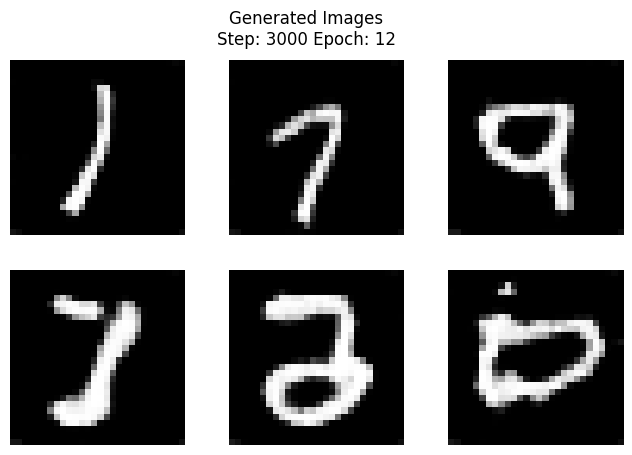

 93%|█████████▎| 3499/3750 [01:23<00:05, 42.81it/s]

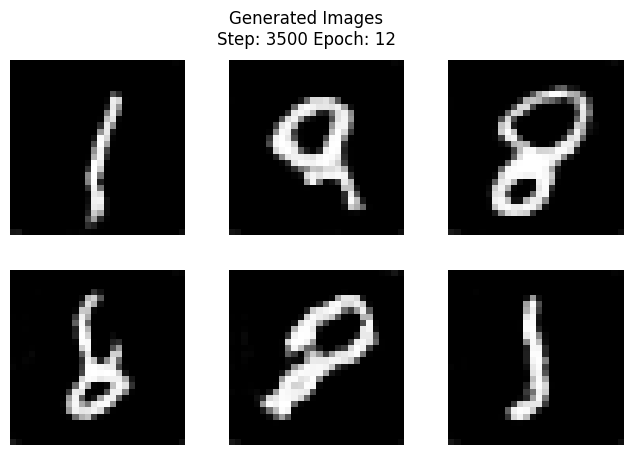

 13%|█▎        | 496/3750 [00:11<01:14, 43.74it/s]

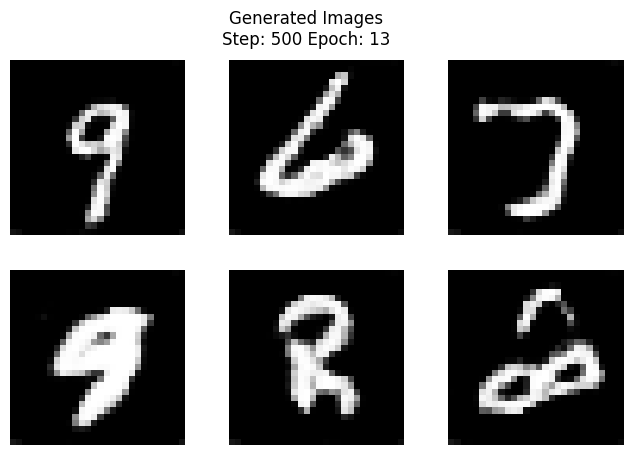

 27%|██▋       | 996/3750 [00:23<01:00, 45.89it/s]

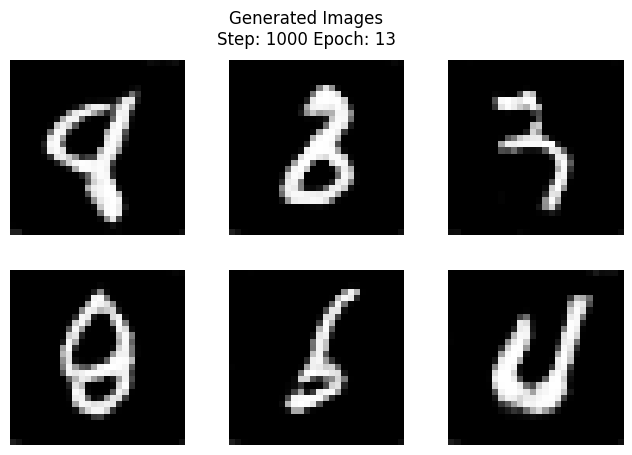

 40%|███▉      | 1499/3750 [00:34<00:54, 41.55it/s]

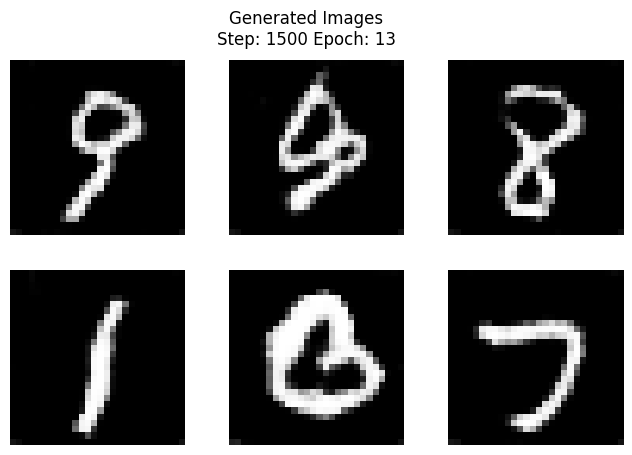

 53%|█████▎    | 1996/3750 [00:46<00:39, 43.93it/s]

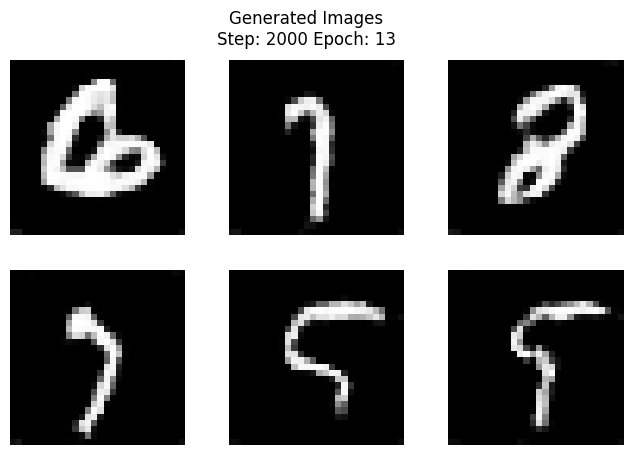

 67%|██████▋   | 2495/3750 [00:58<00:28, 44.60it/s]

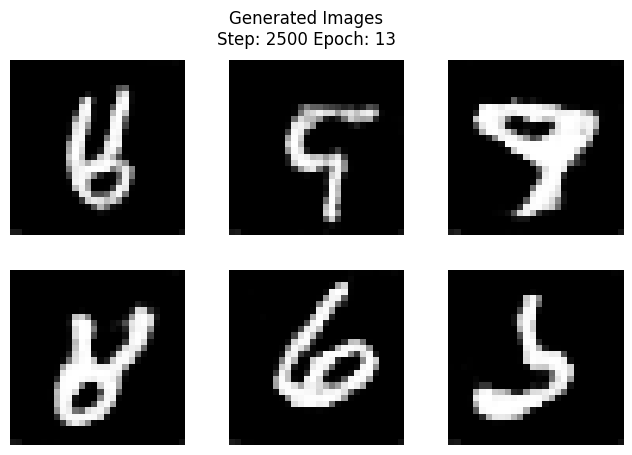

 80%|███████▉  | 2996/3750 [01:09<00:16, 45.70it/s]

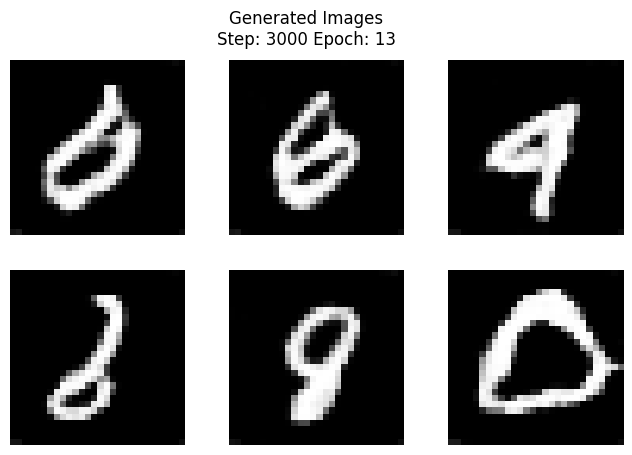

 93%|█████████▎| 3499/3750 [01:20<00:05, 46.34it/s]

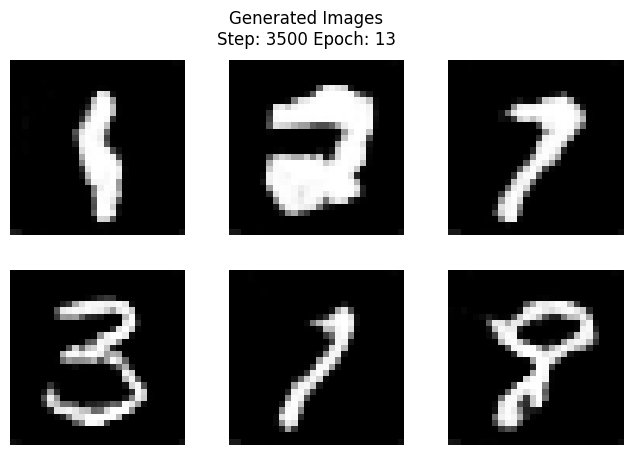

 13%|█▎        | 498/3750 [00:10<01:13, 44.45it/s]

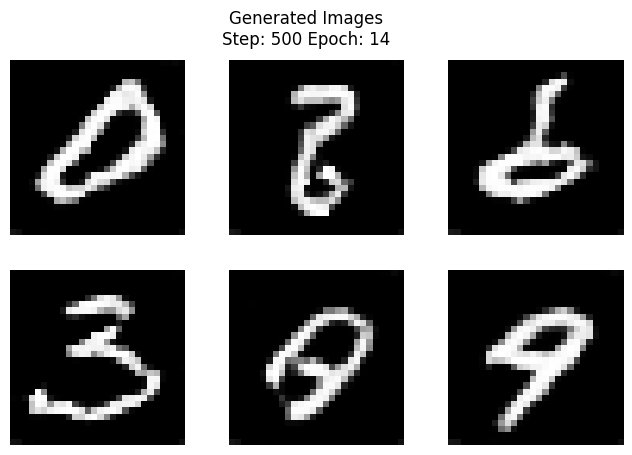

 27%|██▋       | 998/3750 [00:22<00:58, 47.31it/s]

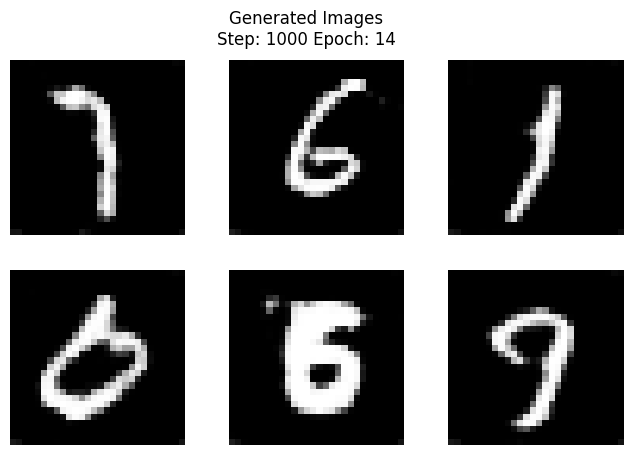

 40%|███▉      | 1499/3750 [00:33<00:49, 45.31it/s]

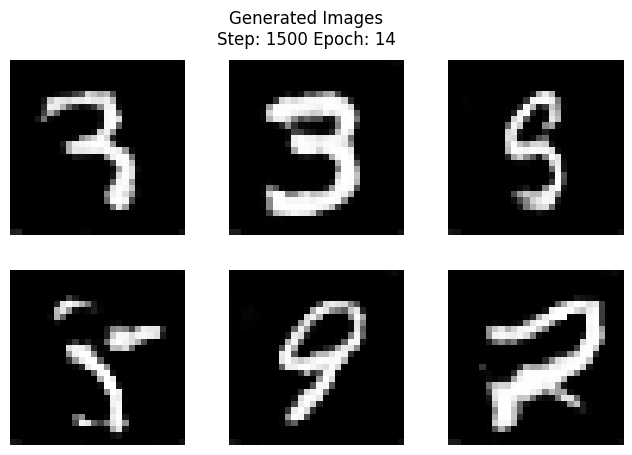

 53%|█████▎    | 1996/3750 [00:45<00:36, 47.76it/s]

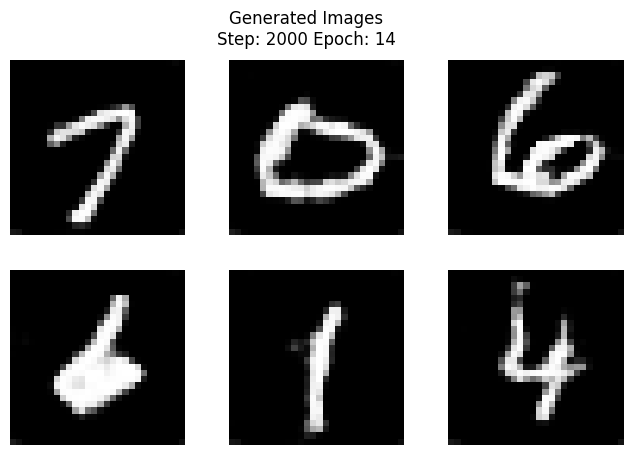

 67%|██████▋   | 2495/3750 [00:56<00:26, 46.67it/s]

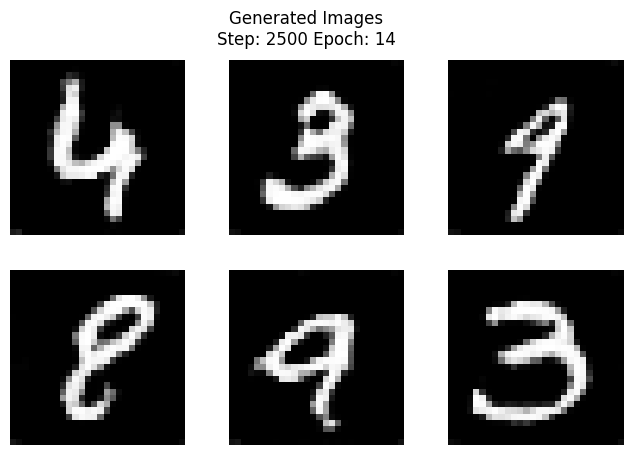

 80%|███████▉  | 2995/3750 [01:07<00:16, 45.02it/s]

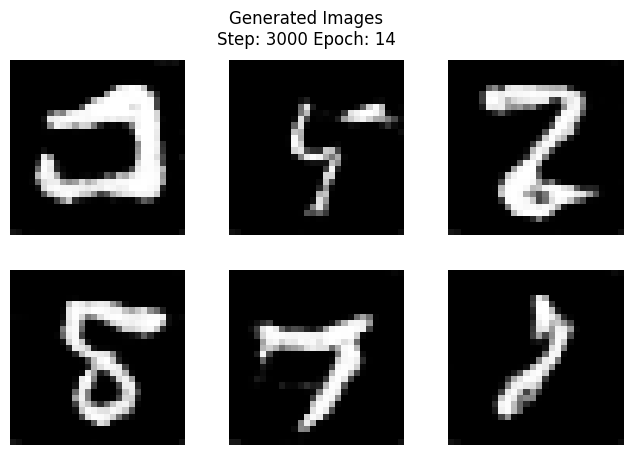

 93%|█████████▎| 3498/3750 [01:19<00:05, 45.74it/s]

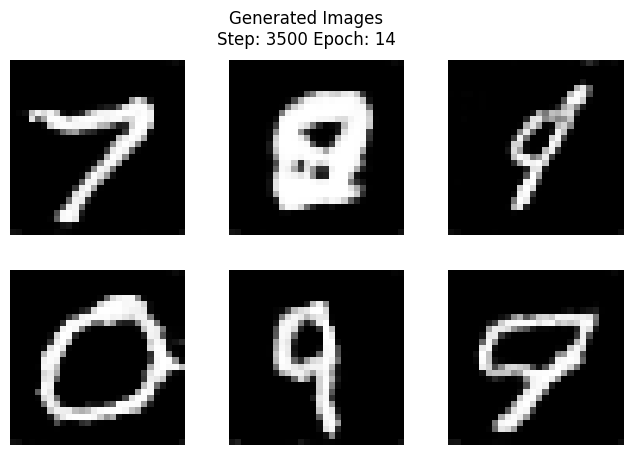

 13%|█▎        | 496/3750 [00:11<01:12, 45.04it/s]

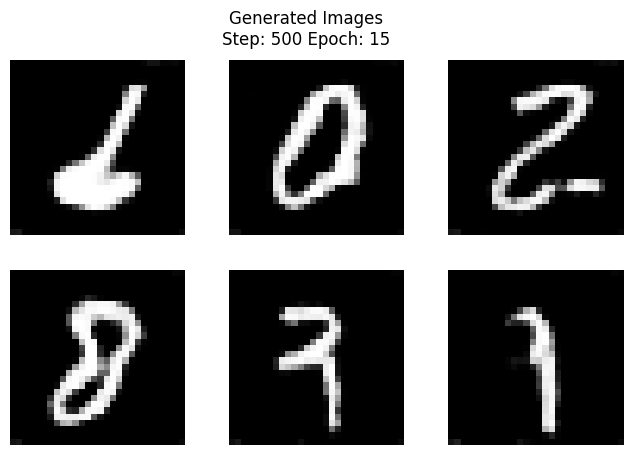

 27%|██▋       | 999/3750 [00:22<01:05, 42.01it/s]

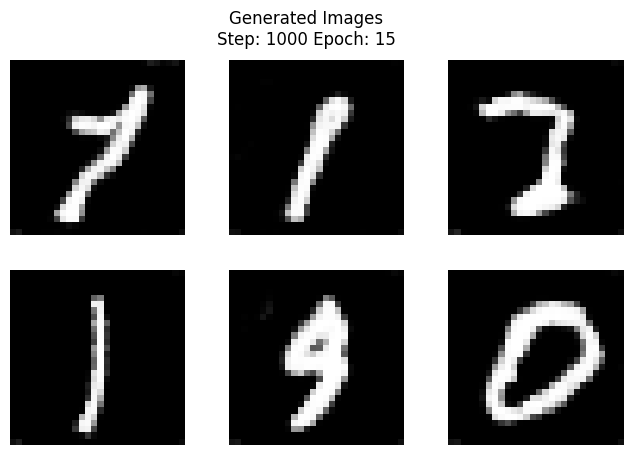

 40%|███▉      | 1496/3750 [00:33<00:51, 43.79it/s]

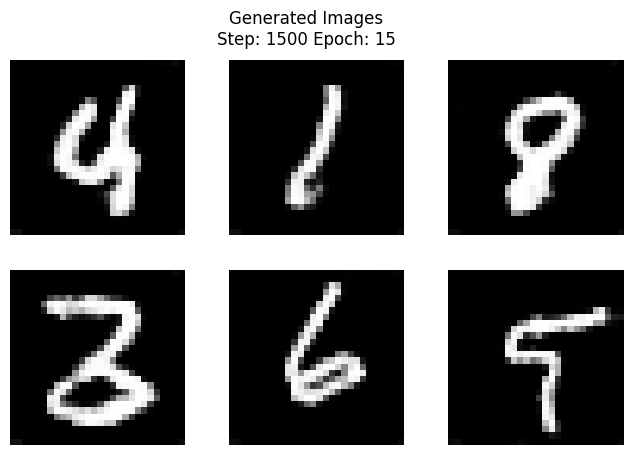

 53%|█████▎    | 1999/3750 [00:45<00:37, 46.26it/s]

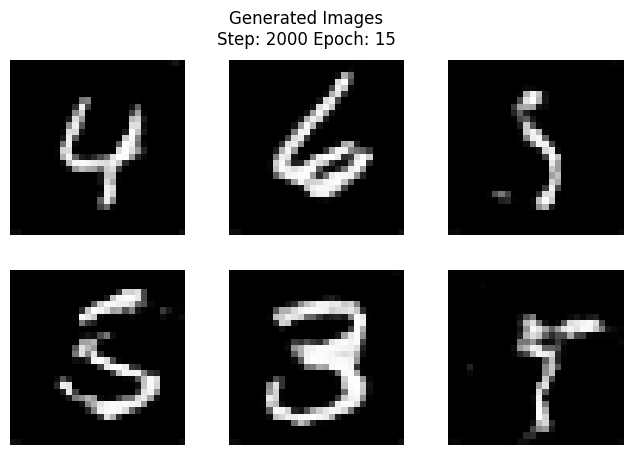

 67%|██████▋   | 2496/3750 [00:56<00:26, 47.15it/s]

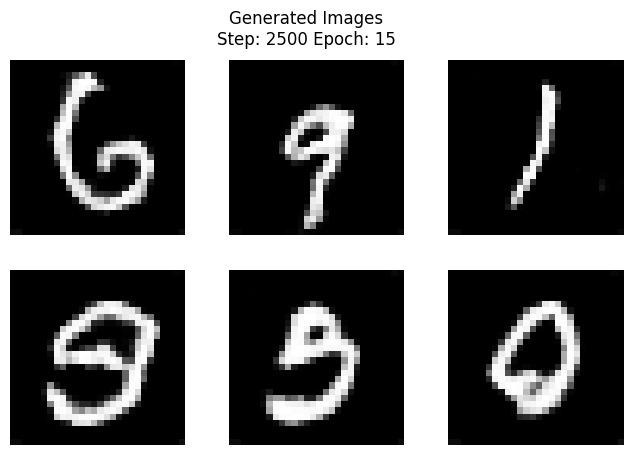

 80%|███████▉  | 2998/3750 [01:08<00:16, 44.38it/s]

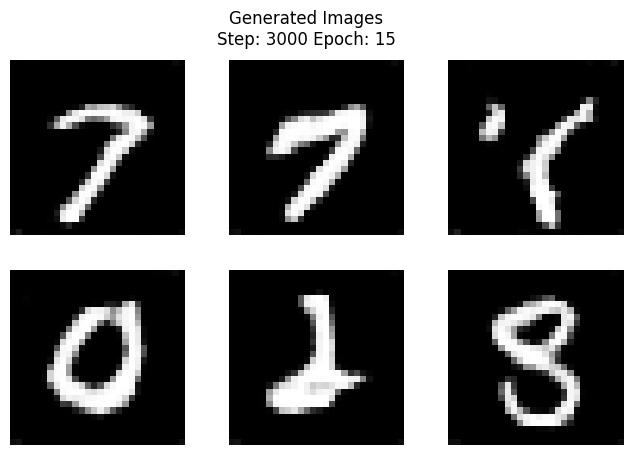

 93%|█████████▎| 3498/3750 [01:20<00:05, 43.71it/s]

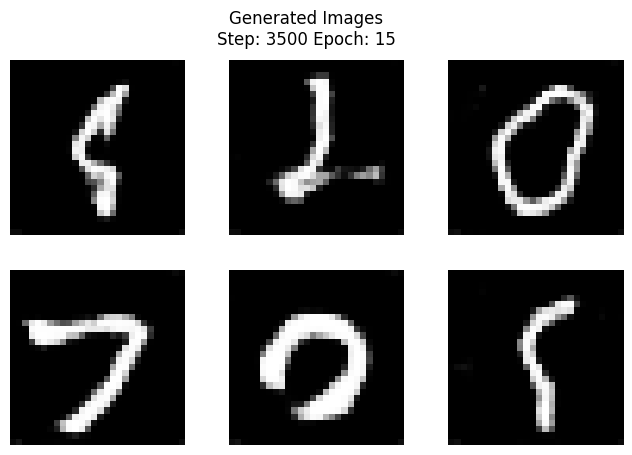

 13%|█▎        | 497/3750 [00:11<01:15, 43.07it/s]

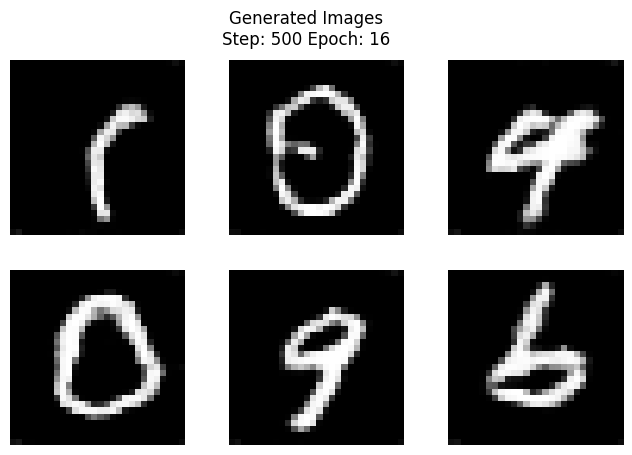

 27%|██▋       | 999/3750 [00:23<01:01, 45.04it/s]

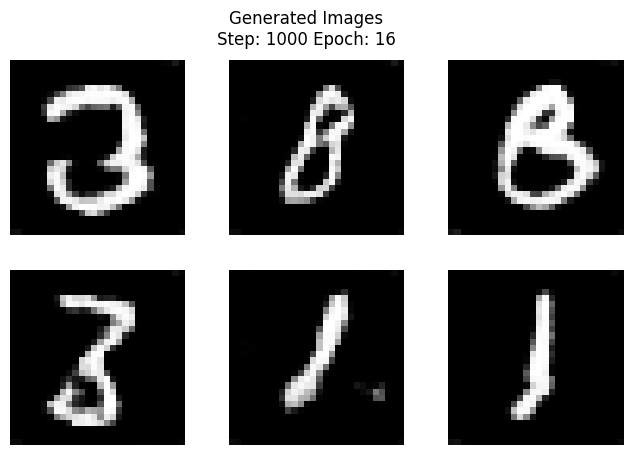

 40%|███▉      | 1495/3750 [00:34<00:50, 44.97it/s]

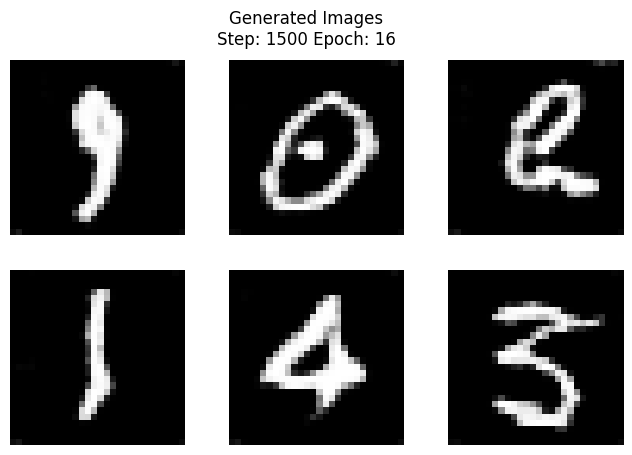

 53%|█████▎    | 1997/3750 [00:45<00:36, 47.84it/s]

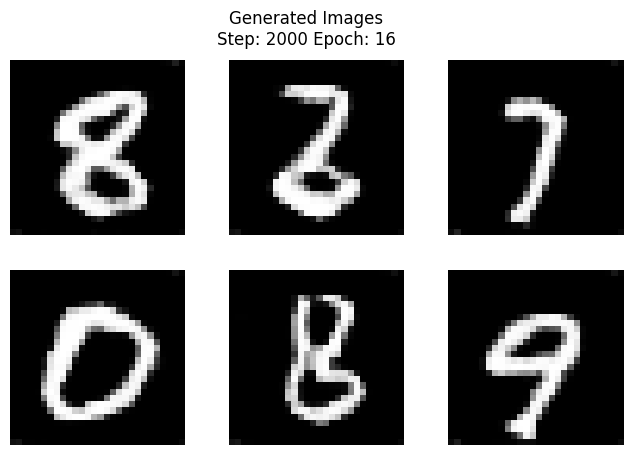

 67%|██████▋   | 2498/3750 [00:57<00:27, 45.28it/s]

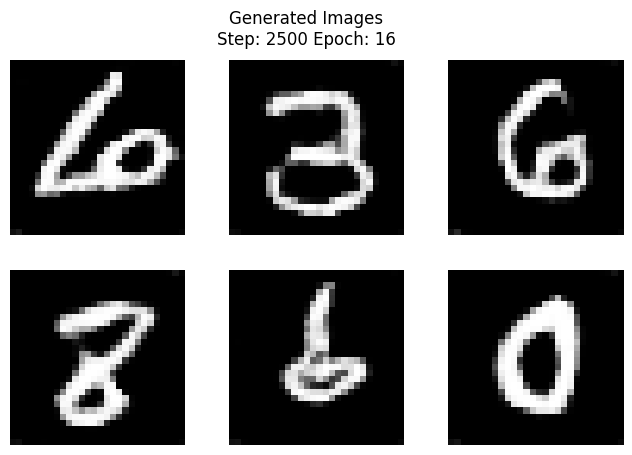

 80%|███████▉  | 2997/3750 [01:09<00:17, 41.95it/s]

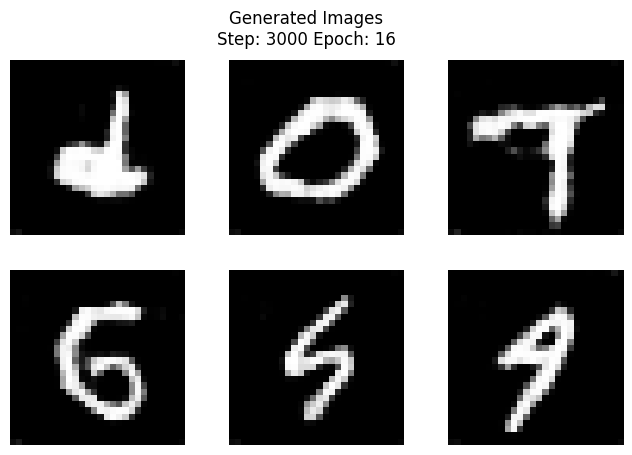

 93%|█████████▎| 3498/3750 [01:20<00:05, 46.99it/s]

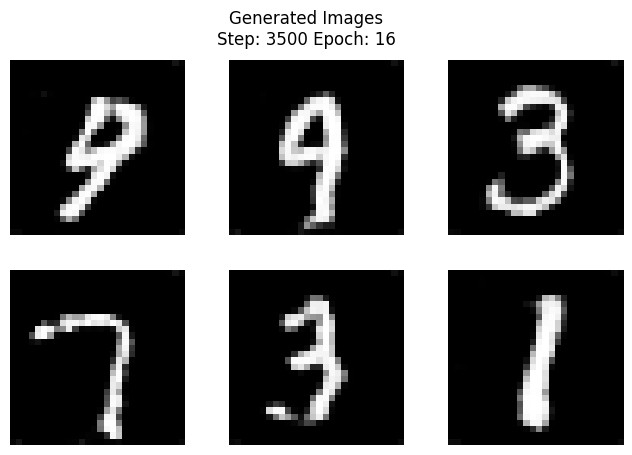

 13%|█▎        | 497/3750 [00:11<01:26, 37.81it/s]

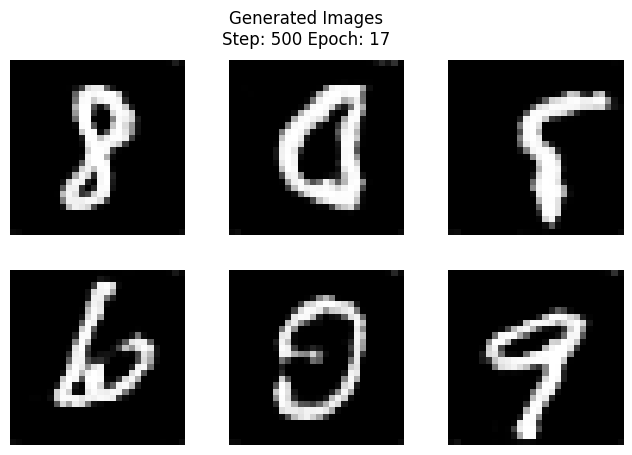

 27%|██▋       | 998/3750 [00:22<01:00, 45.73it/s]

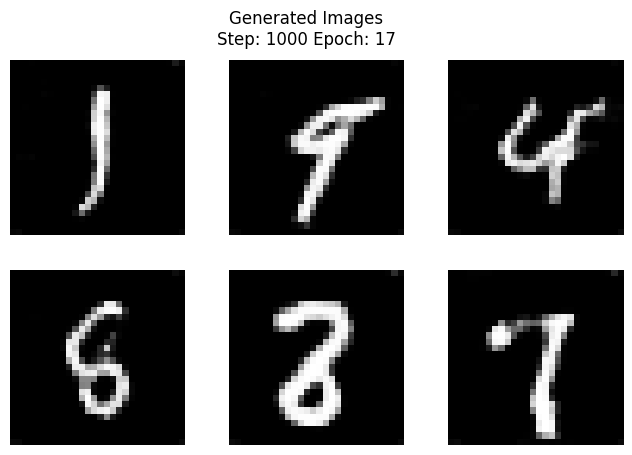

 40%|███▉      | 1498/3750 [00:34<00:50, 44.99it/s]

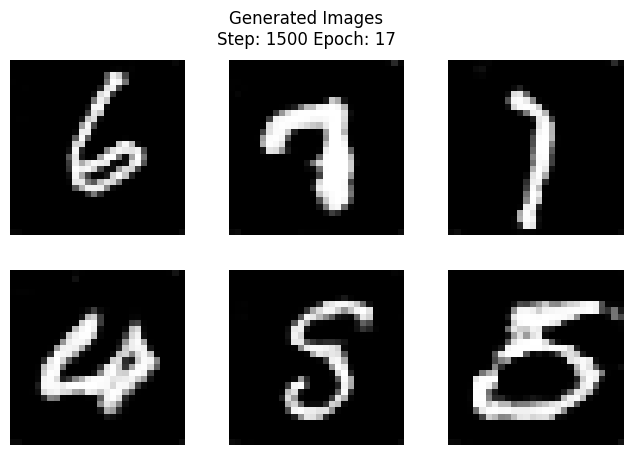

 53%|█████▎    | 1998/3750 [00:45<00:39, 44.33it/s]

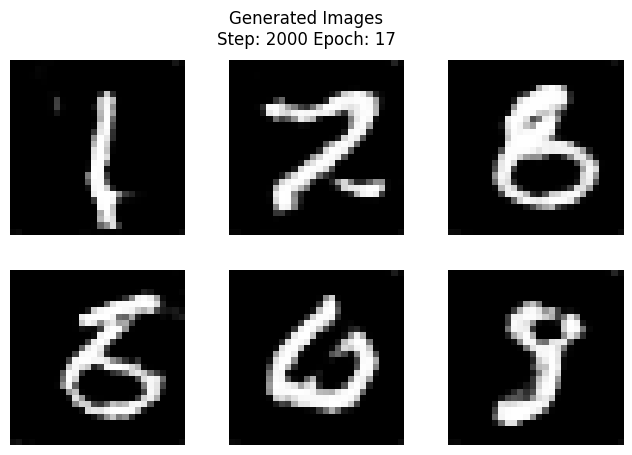

 67%|██████▋   | 2495/3750 [00:56<00:27, 46.47it/s]

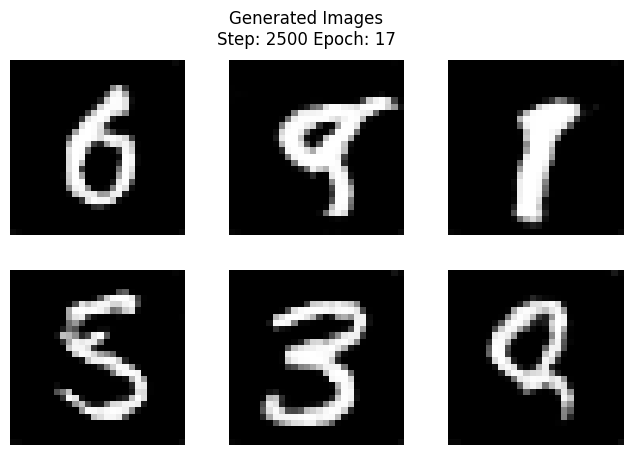

 80%|███████▉  | 2998/3750 [01:07<00:17, 41.93it/s]

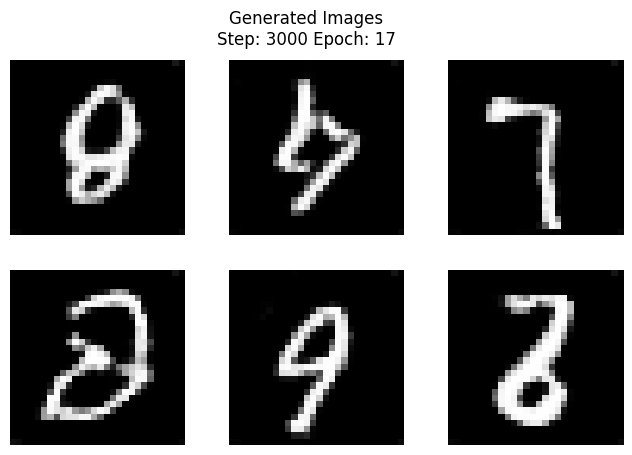

 93%|█████████▎| 3498/3750 [01:20<00:05, 42.99it/s]

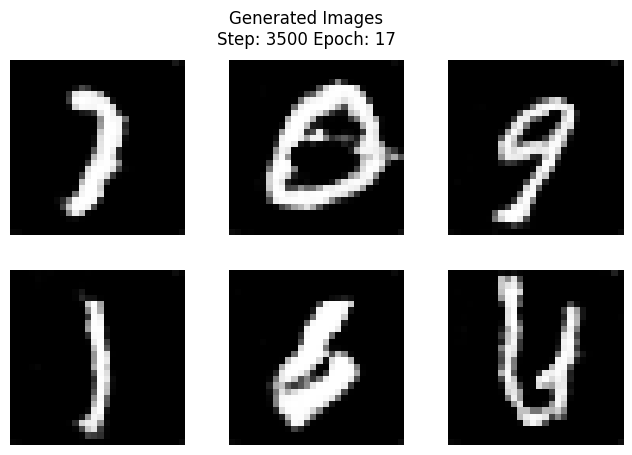

 13%|█▎        | 498/3750 [00:12<01:17, 42.03it/s]

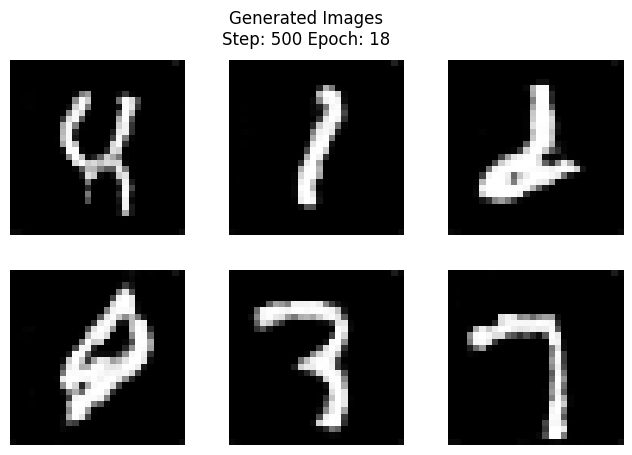

 27%|██▋       | 999/3750 [00:25<00:59, 46.09it/s]

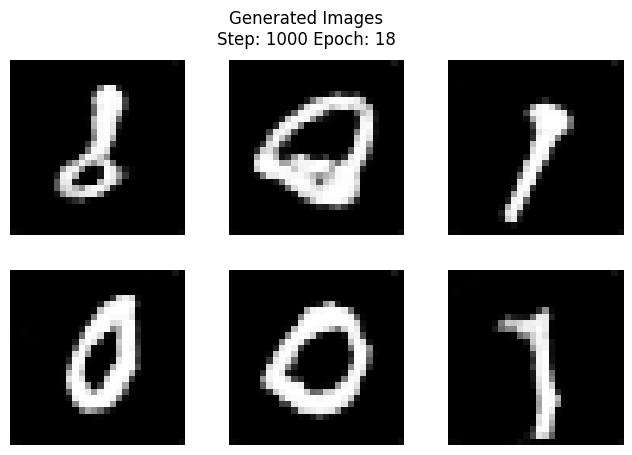

 40%|███▉      | 1497/3750 [00:37<00:49, 45.93it/s]

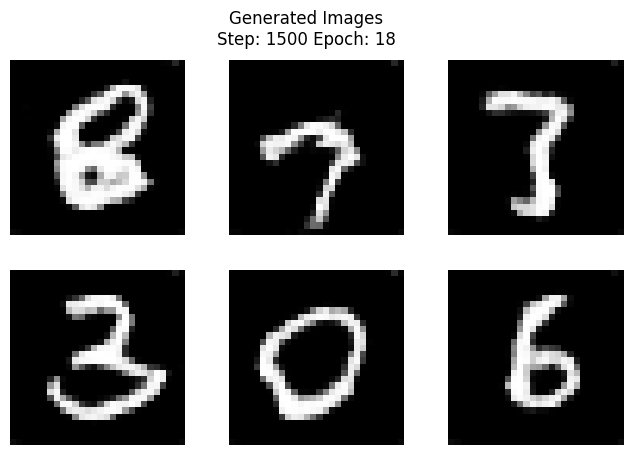

 53%|█████▎    | 1999/3750 [00:50<00:45, 38.70it/s]

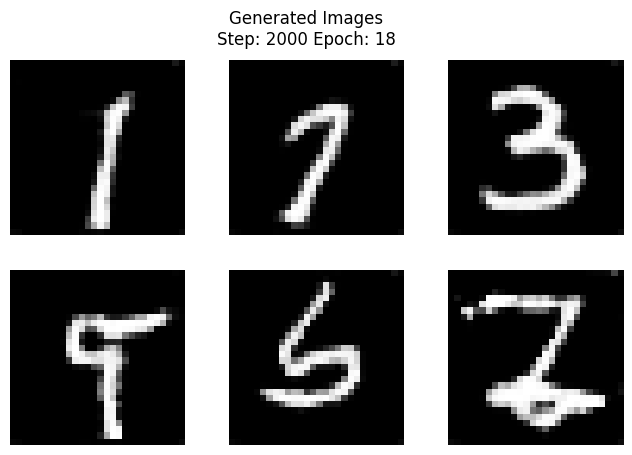

 67%|██████▋   | 2497/3750 [01:01<00:28, 43.81it/s]

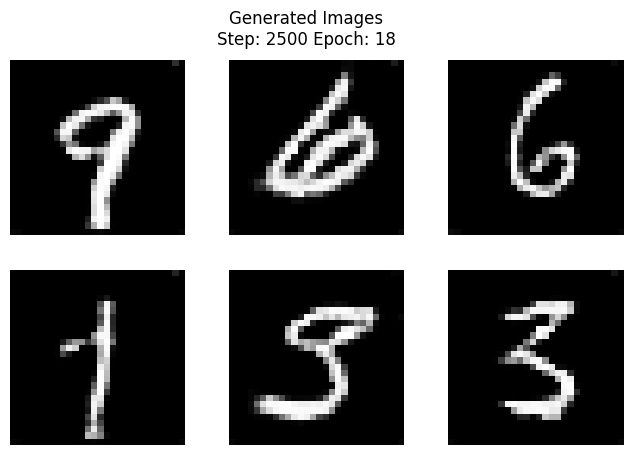

 80%|███████▉  | 2995/3750 [01:13<00:17, 43.52it/s]

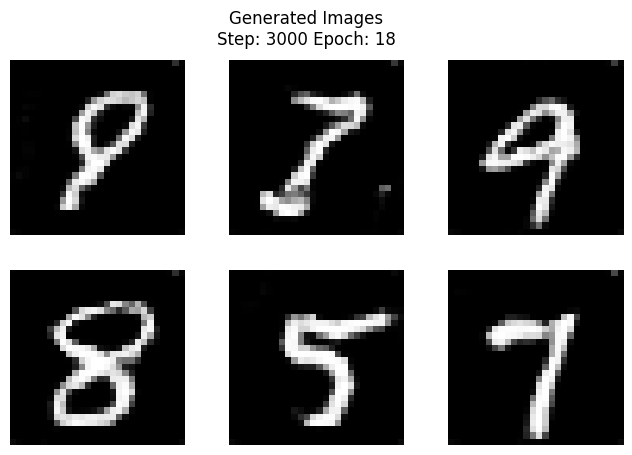

 93%|█████████▎| 3498/3750 [01:25<00:06, 41.88it/s]

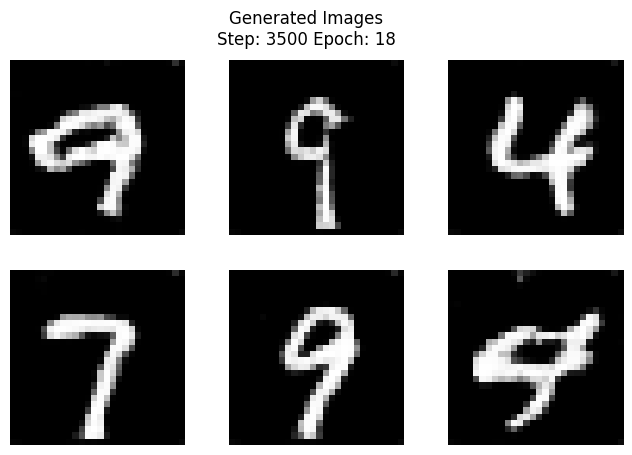

 13%|█▎        | 499/3750 [00:12<01:23, 39.15it/s]

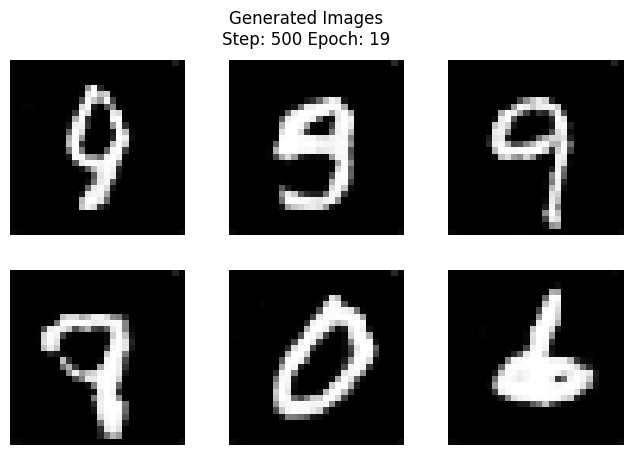

 27%|██▋       | 998/3750 [00:25<01:01, 44.59it/s]

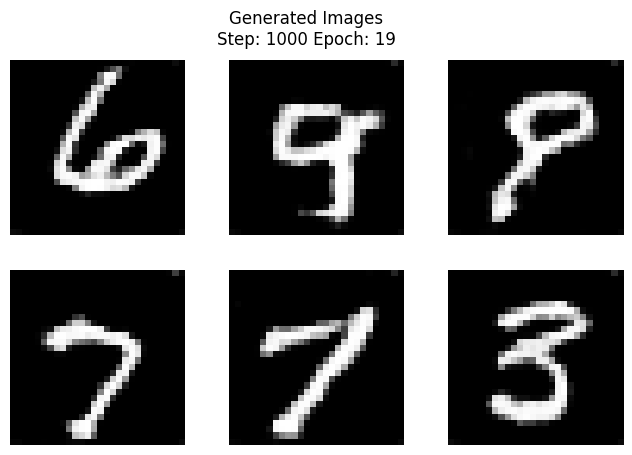

 40%|███▉      | 1497/3750 [00:37<00:52, 42.56it/s]

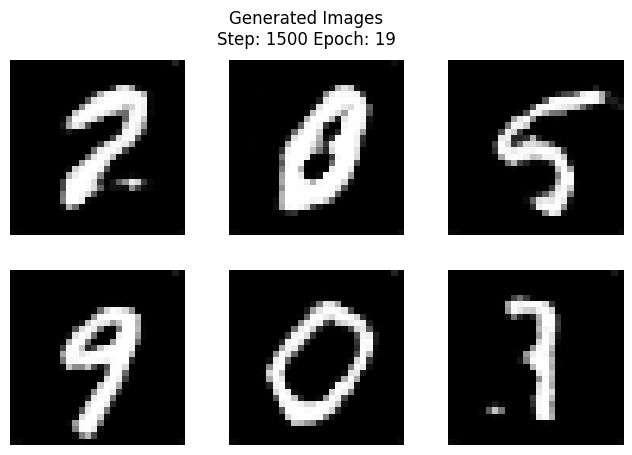

 53%|█████▎    | 1999/3750 [00:49<00:43, 40.15it/s]

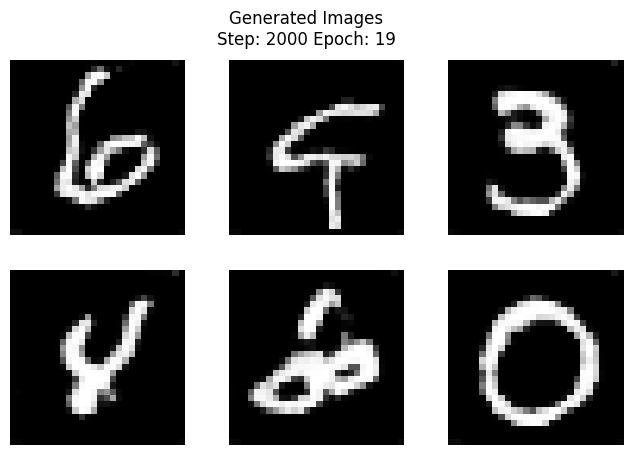

 67%|██████▋   | 2497/3750 [01:00<00:27, 45.17it/s]

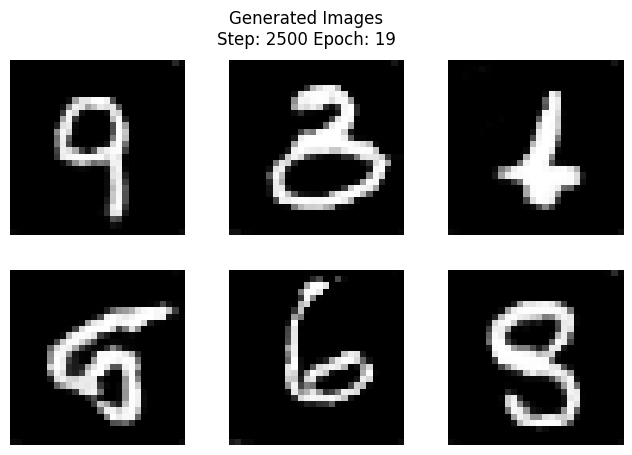

 80%|███████▉  | 2995/3750 [01:12<00:17, 44.01it/s]

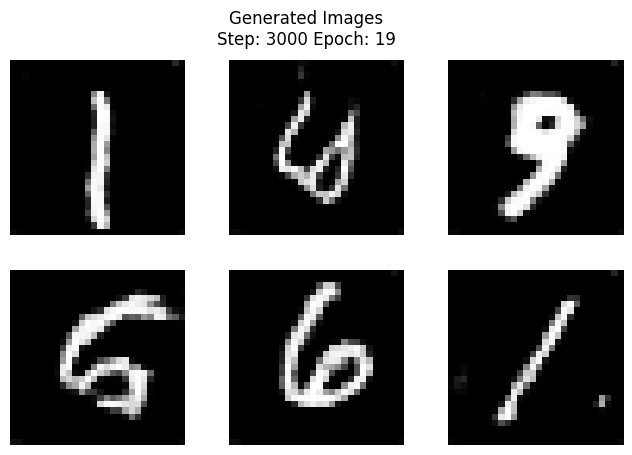

 93%|█████████▎| 3497/3750 [01:24<00:06, 38.64it/s]

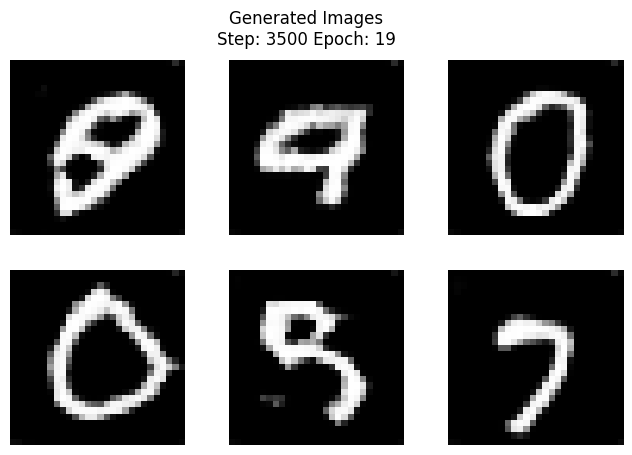

 13%|█▎        | 497/3750 [00:12<01:16, 42.34it/s]

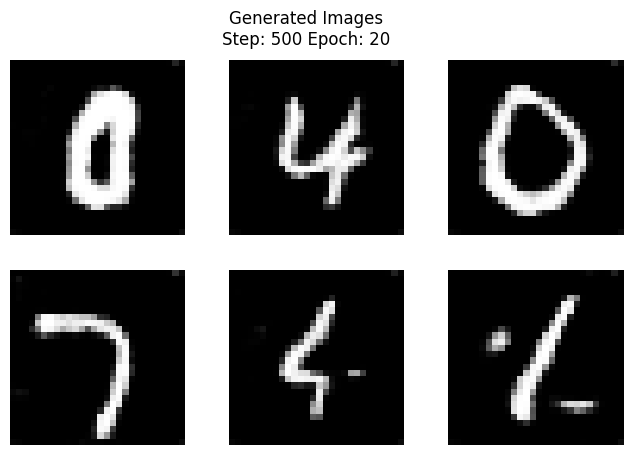

 27%|██▋       | 999/3750 [00:24<01:08, 40.34it/s]

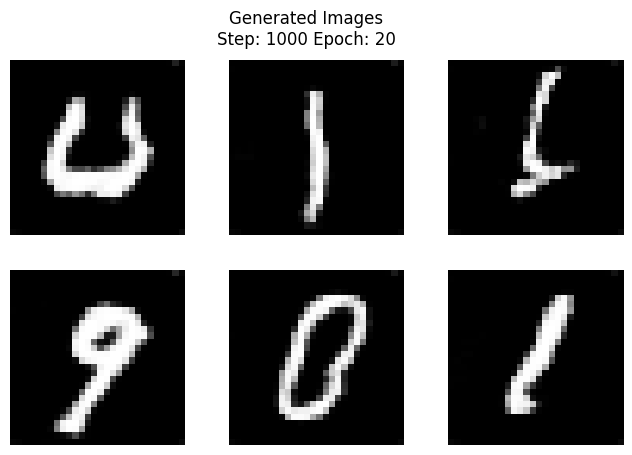

 40%|███▉      | 1496/3750 [00:35<00:51, 44.04it/s]

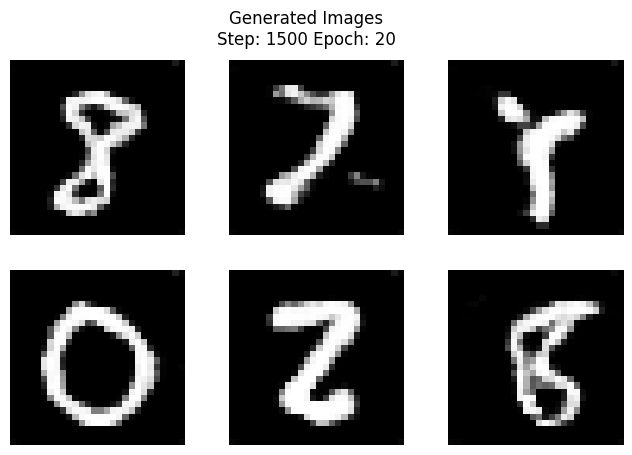

 53%|█████▎    | 1997/3750 [00:48<00:37, 46.59it/s]

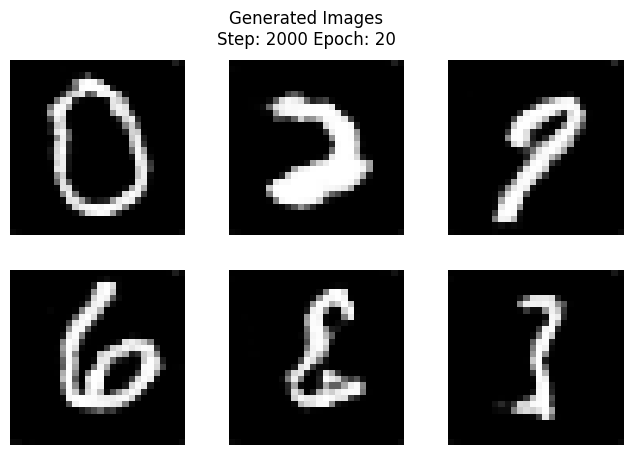

 67%|██████▋   | 2499/3750 [01:00<00:30, 40.38it/s]

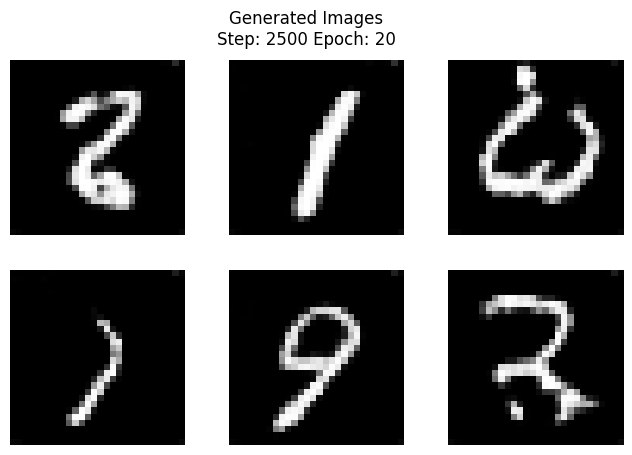

 80%|███████▉  | 2997/3750 [01:12<00:15, 47.27it/s]

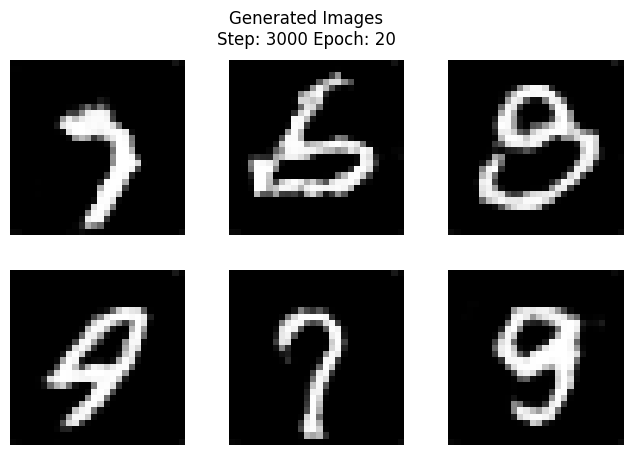

 93%|█████████▎| 3497/3750 [01:24<00:06, 41.29it/s]

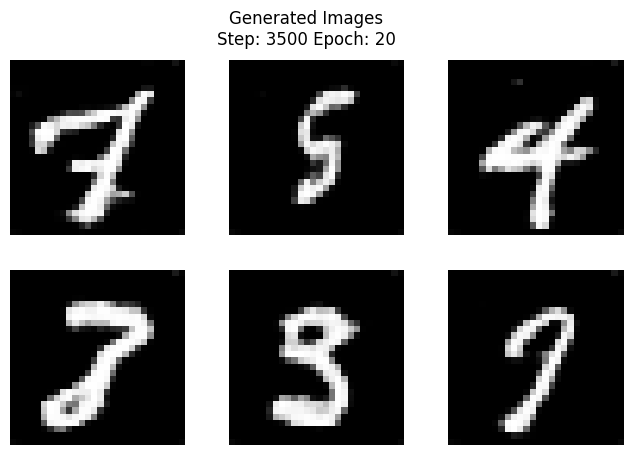

100%|██████████| 3750/3750 [01:31<00:00, 41.06it/s]


In [13]:
STEPS = len(dataloader)

# Training for n number of epochs
for epoch in range(1, EPOCHS+1):

    steps = 1

    # Training steps
    for real_images, _ in tqdm(dataloader):

        # Current Step Configs
        curr_batch_size = len(real_images)
        real_images = real_images.to(DEVICE)

        # Discriminator training
        discriminator_optim.zero_grad()

        noise = generate_noise(curr_batch_size)
        syn_images = generator(noise)

        syn_disc_preds = discriminator(syn_images.detach())
        syn_disc_loss = criterion(syn_disc_preds, torch.zeros_like(syn_disc_preds))

        real_disc_preds = discriminator(real_images)
        real_disc_loss = criterion(real_disc_preds, torch.ones_like(real_disc_preds))

        # Total discriminator loss
        discriminator_loss = (real_disc_loss + syn_disc_loss)/2

        discriminator_loss.backward(retain_graph=True)
        discriminator_optim.step()


        # Generator training
        generator_optim.zero_grad()

        noise = generate_noise(curr_batch_size)
        syn_images = generator(noise)

        syn_disc_preds = discriminator(syn_images)
        generator_loss = criterion(syn_disc_preds, torch.ones_like(syn_disc_preds))

        generator_loss.backward()
        generator_optim.step()


        # Visualize training
        if (steps % DISPLAY_STEP == 0):

            noise = generate_noise(25)
            synthetic_images = generator(noise)

            show_generations(
                synthetic_images, 2, 3,
                figsize=(8, 5),
                title=f"Generated Images\nStep: {steps} Epoch: {epoch}",
                save_loc = f"./GeneratorImages/Epoch_{epoch}/synthetic_image_{steps}.png"
            )

            # Uncomment only if you don't want training genration visualization outputs.
            # time.sleep(1)
            # clear_output(wait=True)

        # Update counter
        steps += 1

Epochs Overview:

1. **Epoch 1:** In the initial training phase, the model grasped the basics – understanding that the center should contain more white pixels, while the outer corners demanded a prevalence of black pixels. Although lacking broader context, this foundational learning set the stage.

2. **Epoch 2:** Significant progress unfolded as the model recognized the need for entirely black pixels around corners and pure white pixels at the center to deceive the discriminator. However, the model's knowledge was limited to a few closed shapes, revealing a gap in understanding other classes.

3. **Epoch 3:** Despite a modest leap, the model achieved clearer image generation. However, contextual information remained elusive, hindering its ability to distinguish between different numbers.

4. **Epoch 4-7:** These epochs marked an earnest effort to grasp contextual information, leading to attempts at generating specific numbers. While the results were recognizable, they fell short of full conviction, particularly for numbers like 907 and 5.

5. **Epoch 8:** A critical juncture unfolded as the model began generating mixed images, blending multiple numbers. Some downgrading in quality was observed, highlighting the inherent challenges in GAN training.

6. **Epoch 9:** A remarkable turnaround occurred, with the model producing highly upgraded, clear, and realistic images. The contextual information was well-defined, showcasing the model's adaptability and learning capacity.

7. **Epoch 10-13:** The training dynamics revealed a continuous evolution of strategies. While occasional deviations occurred, indicating experimentation and learning, overall, the model demonstrated stability and improvement.

8. **Epoch 14-18:** Stability became pronounced during this phase, with the model consistently generating realistic and contextually rich images. The learning curve showcased the model's enhanced proficiency in capturing finer details.

9. **Epoch 19, 20:** A temporary dip in the model's performance was noted, possibly attributed to strategic experimentation. However, the final output demonstrated resilience, with the model generating highly realistic and impressive images.

This training journey encapsulates the iterative nature of GANs, illustrating moments of struggle, experimentation, and ultimate mastery. The model's ability to adapt, learn, and produce convincing results underscores the effectiveness of the training process.

# **Model Generations 🖼️**

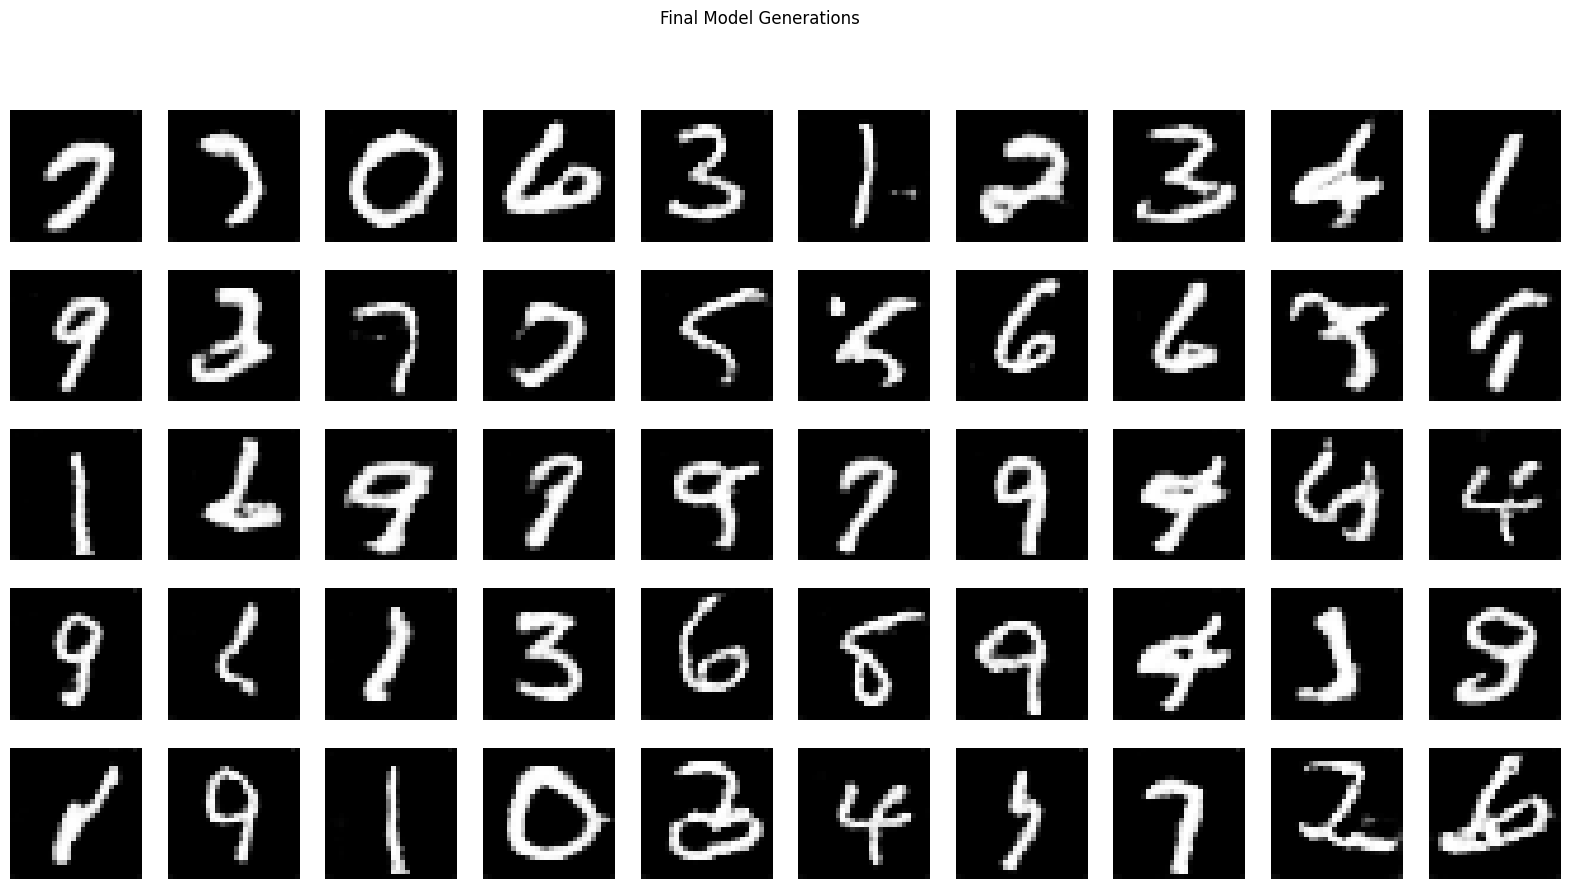

In [14]:
noise = generate_noise(50)
synthetic_images = generator(noise)

show_generations(
    synthetic_images, 5, 10,
    figsize=(20, 10),
    title=f"Final Model Generations",
    save_loc = f"./FinalModelGeneration.png"
)

The model's **generative prowess** is **undeniably impressive**, with **certain outputs** exhibiting a **remarkable level of realism**. However, a **discerning eye reveals** that **not all generated samples** achieve **a genuine, realistic quality**. While some are **strikingly convincing**, others **bear noticeable traits that distinguish them as synthetic images**. The spectrum ranges from **exceptionally authentic** to instances where the **artificial nature** becomes **discernible upon closer inspection**.

# **Similarity Score 💯**

In [15]:
ssim_scores = []
for batch in range(10):
    # Generate Images
    real_images, _ = next(iter(dataloader))
    noise = generate_noise(len(real_images))
    syn_images = generator(noise).detach().cpu()

    # Compute Similarity score
    score = ssim(real_images, syn_images)
    print(f"Batch : {batch+1:2} Similarity Score: {score}")

    ssim_scores.append(score)

Batch :  1 Similarity Score: 0.9377331733703613
Batch :  2 Similarity Score: 0.9432977437973022
Batch :  3 Similarity Score: 0.9439511299133301
Batch :  4 Similarity Score: 0.9372819066047668
Batch :  5 Similarity Score: 0.9373573064804077
Batch :  6 Similarity Score: 0.9312940835952759
Batch :  7 Similarity Score: 0.9391500949859619
Batch :  8 Similarity Score: 0.9327281713485718
Batch :  9 Similarity Score: 0.9286678433418274
Batch : 10 Similarity Score: 0.9417352080345154


In [16]:
fig = px.line(ssim_scores, title="SSIM Scores")
fig.update_layout(
    xaxis_title = "Batches",
    yaxis_title = "Score",
    showlegend = False
)
fig.show()

In [17]:
print(f"Average SSIM: {np.mean(ssim_scores)}")

Average SSIM: 0.9373196363449097


The **Average Structural Similarity Index (SSIM)** score of **0.9401** is indicative of **high similarity** between the **generated images** and the **real images**.

**SSIM values range from -1 to 1**, where **1 signifies perfect similarity**. In this context, a score of **0.9401** suggests that the **generated images** closely resemble the **real images**, showcasing a **strong correspondence** in terms of **structural information, luminance, and contrast**.

An **SSIM score of 0.9401** is generally considered **excellent and indicates** that the **generative model** has successfully **learned** to **produce images that maintain a high degree of similarity to the ground truth**.

Overall, achieving such a **high average SSIM** is a **positive outcome**, signifying the **effectiveness of the generative model** in capturing and **reproducing key visual features from the real images.**

# **Summary 📔**

Throughout this explorative journey into the **realm of Generative Adversarial Networks (GANs),** our focus has been on **understanding, implementing, and refining a Spectral Normalization Generative Adversarial Network (SN GAN) for image generation**.

* The journey began with a **foundational explanation** of **GANs**, diving into the **architecture of DC GANs (Deep Convolutional GANs)** as a precursor to **SN GANs**. The **adversarial interplay between the generator and discriminator** in **generating realistic synthetic images was elucidated**, framing it as a **dynamic game** where both entities **iteratively enhance their capabilities.**

* The **challenges inherent** in **GAN training**, including **mode collapse and instability,** were unveiled, setting the **stage for the introduction of Spectral Normalization (SN).** **SN GANs** leverage **spectral normalization** on the **discriminator's convolutional layers** to **foster stability** and **mitigate training issues**, paving the way for **more effective and reliable image generation.**

* We delved into the **architecture of the SN GAN**, dissecting the **generator's composition** from **input layers** to **convolutional transpose layers**. The integration of **spectral normalization** emerged as a **crucial enhancement**, **fostering a balance between complexity and stability in the learning process.**

* The narrative then transitioned to the **practical implementation** of the **SN GAN**. A meticulously **crafted Generator class** encapsulates the **model's structure**, while the creation of **noise vectors** serves as the **foundational step in the generative process**.

* With a refined **SN GAN** in hand, the **training process unfolded across epochs**, each revealing the **model's evolving understanding** of **image generation**. From the **blurry yet purposeful initial stages** to the **emergence of specific numbers and the subsequent refinement of subtle, believable images, the model's journey mirrored the nuances of learning embedded in adversarial training.**

* To evaluate the **model's performance**, the **Structural Similarity Index (SSIM)** was employed as a metric. The **SSIM scores**, showcasing a progression from **mixed outputs to specific, discernible numbers, ultimately culminated** in an **impressive average SSIM of 0.9401**. This score underscored the **model's ability** to **generate images with a remarkably high degree of similarity to real images**.

In summary, our expedition navigated the **intricacies of GANs**, **SN GANs,** and their **training dynamics**. From theoretical underpinnings to practical implementation, the journey unfolded in stages, culminating in a robust **SN GAN** capable of **generating images** with **striking fidelity**. The **SSIM metric** served as **a quantitative lens**, affirming the model's proficiency in capturing and reproducing key visual features.

As we conclude this exploration, the **SN GAN** stands not only as a testament to the advancements in **generative modeling** but also as **an embodiment of the iterative learning** inherent in the **adversarial pursuit of realistic image synthesis.**